# Continuous Assesment 1

# An Investigation into Visitor Arrivals to Ireland 

### Ireland has always been a popular destination from visitors all over the world but where do these visitors come from? How have visitor numbers fluctuated over the years and what does the future look like?

In [1]:
#import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

Read in dataset and inspect contents

In [2]:
#dataset taken from CSO's Open Data Platform (Data.cso.ie, 2020)
travel_df = pd.read_csv("travel.csv")

In [3]:
#use .head() function to inspect df structure and contents of columns
travel_df.head()

STATISTIC Label         Month        Country   Direction      UNIT  \
0  Air and Sea Travel  2010 January  Great Britain    Arrivals  Thousand   
1  Air and Sea Travel  2010 January  Great Britain  Departures  Thousand   
2  Air and Sea Travel  2010 January   Other UK (1)    Arrivals  Thousand   
3  Air and Sea Travel  2010 January   Other UK (1)  Departures  Thousand   
4  Air and Sea Travel  2010 January        Belgium    Arrivals  Thousand   

   VALUE  
0  361.5  
1  407.6  
2    0.9  
3    1.1  
4   12.5

In [4]:
#inspect size of dataframe 
travel_df.shape

(6084, 6)

In [5]:
#view last 5 rows of dataframe
travel_df.tail()

STATISTIC Label         Month               Country   Direction  \
6079  Air and Sea Travel  2024 January  United Arab Emirates  Departures   
6080  Air and Sea Travel  2024 January   Other Countries(42)    Arrivals   
6081  Air and Sea Travel  2024 January   Other Countries(42)  Departures   
6082  Air and Sea Travel  2024 January         All countries    Arrivals   
6083  Air and Sea Travel  2024 January         All countries  Departures   

          UNIT   VALUE  
6079  Thousand    30.7  
6080  Thousand    37.2  
6081  Thousand    34.7  
6082  Thousand  1302.5  
6083  Thousand  1281.7

In [6]:
travel_df.describe()

VALUE
count  6080.000000
mean    136.604638
std     316.126348
min       0.000000
25%      12.800000
50%      36.100000
75%      85.400000
max    2270.700000

In [7]:
#use .describe() function to gain better understanding of dataset
travel_df.describe(include=object)

STATISTIC Label         Month        Country Direction      UNIT
count                 6084          6084           6084      6084      6084
unique                   1           169             18         2         1
top     Air and Sea Travel  2010 January  Great Britain  Arrivals  Thousand
freq                  6084            36            338      3042      6084

# Data Preparation and manipulation of original dataset

Now that original dataframe has been explored using basic functions it is time to manipulate the columns and rows to make the data more suitable for this investigation

In [8]:
#drop unnecessary columns using .drop() function
arrivals_df=travel_df.drop(["STATISTIC Label"], axis=1)

In [9]:
#Remove all the departure rows (only interested in inbound passengers)
arrivals_df=arrivals_df[arrivals_df["Direction"]!="Departures"]

I don't need the UNIT column. Create an equation that will form a new column called "Visitors" by multiplying "VALUE" column value by 1000. This will make my table more concise.

In [10]:
#create function calculate_visitors
def calculate_visitors(arrivals_df, travel_df):
    arrivals_df["Visitors"] = travel_df["VALUE"] * 1000
    
calculate_visitors(arrivals_df, travel_df)

Weiss, S. (2024). Functions - Part 2. [Lecture].

In [11]:
#drop columns no longer required
arrivals_df=arrivals_df.drop(columns=["UNIT","VALUE"])

In [12]:
#inspect types of data I have
arrivals_df.dtypes

Month         object
Country       object
Direction     object
Visitors     float64
dtype: object

In [13]:
arrivals_df.head()

Month        Country Direction  Visitors
0  2010 January  Great Britain  Arrivals  361500.0
2  2010 January   Other UK (1)  Arrivals     900.0
4  2010 January        Belgium  Arrivals   12500.0
6  2010 January        Germany  Arrivals   45300.0
8  2010 January          Spain  Arrivals   68600.0

In [14]:
arrivals_df.shape

(3042, 4)

In [15]:
#check for missing values
arrivals_df.isnull().values.any()

True

In [16]:
#inspect which columns have missing values and how many there are.
arrivals_df.isnull().sum()

Month        0
Country      0
Direction    0
Visitors     2
dtype: int64

In [17]:
#view my missing values
missing_visitors_df = arrivals_df[arrivals_df['Visitors'].isnull()]
print(missing_visitors_df)

             Month       Country Direction  Visitors
4754  2021 January  Other UK (1)  Arrivals       NaN
5078  2021 October  Other UK (1)  Arrivals       NaN


## Split the "Month" column into Year and Date

### Creating 2 seperate columns for year and month allows to look at specific months within years

In [18]:
#rename "Month" column to "Date" and change to datetime (pandas.pydata.org, 2024)
arrivals_df["Date"]=pd.to_datetime(arrivals_df["Month"])

C:\Users\a-ldrumm\AppData\Local\Temp\ipykernel_48544\2265613212.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  arrivals_df["Date"]=pd.to_datetime(arrivals_df["Month"])


In [19]:
#create 2 new columns for month and year
arrivals_df['Year'] = arrivals_df['Date'].dt.year
arrivals_df['Month'] = arrivals_df['Date'].dt.month

## Replacing the Missing Values:

In [20]:
#calculating the mean no. of arrivals from other UK in 2021
average_visitors_2021 = arrivals_df[(arrivals_df['Country'] == 'Other UK (1)') & (arrivals_df['Visitors'].notnull()) & (arrivals_df['Year'] == 2021)]['Visitors'].mean()
average_visitors_2021

100.0

In [21]:
#replacing NaN values with average for that year 
arrivals_df.loc[(arrivals_df['Country'] == 'Other UK (1)') & (arrivals_df['Year'] == 2021) & (arrivals_df['Month'].isin([1, 10])) & (arrivals_df['Visitors'].isnull()), 'Visitors'] = average_visitors_2021

pandas.pydata.org. (2024b). Working with missing data — pandas 1.2.4 documentation. [online] Available at: https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html.

In [22]:
#check that missing data has been dealt with
arrivals_df.isnull().sum()

Month        0
Country      0
Direction    0
Visitors     0
Date         0
Year         0
dtype: int64

# Adding a New Column for Longitude and Latitude:

In [23]:
#import tools
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim

In [24]:
geolocator = Nominatim(user_agent='my_app_name')
geolocator.timeout=10 #increasing timeout so my code runs

In [25]:
#function find_geocode created to generate geographical coordinates for countries listed
def find_geocode(country):
    try:
        return geolocator.geocode(country)
    except GeocoderTimedOut:
        return find_geocode(country)

In [26]:
#conditional statement that will assign longitude and latitude to a country but return NaN value if one is not found
latitude = []
longitude = []
for country in arrivals_df['Country']:
    location = find_geocode(country)
    if location:
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    else:
        latitude.append(np.nan)
        longitude.append(np.nan)

geopy.readthedocs.io. (2006). Welcome to GeoPy’s documentation! — GeoPy 2.3.0 documentation. [online] Available at: https://geopy.readthedocs.io/en/stable/#module-geopy.geocoders.

In [27]:
#Crate 2 new columns to store this data
arrivals_df["Latitude"]=latitude
arrivals_df["Longitude"]=longitude

In [28]:
#Inspect if function worked correctly and investigate which entries returned NaN values (can they be removed?)
arrivals_df.head(20)

Month                                            Country Direction  \
0       1                                      Great Britain  Arrivals   
2       1                                       Other UK (1)  Arrivals   
4       1                                            Belgium  Arrivals   
6       1                                            Germany  Arrivals   
8       1                                              Spain  Arrivals   
10      1                                             France  Arrivals   
12      1                                              Italy  Arrivals   
14      1                                        Netherlands  Arrivals   
16      1                                             Poland  Arrivals   
18      1                                           Portugal  Arrivals   
20      1  Selected EU (AT,BG,CY,CZ,DK,EE,FI,GR,HR,HU,LT,...  Arrivals   
22      1                                        Switzerland  Arrivals   
24      1                                  Other Europe (34)  Arrivals   
26      1                                      United States  Arrivals   
28      1                   Other Transatlantic Countries(1)  Arrivals   
30      1                               United Arab Emirates  Arrivals   
32      1                                Other Countries(42)  Arrivals   
34      1                                      All countries  Arrivals   
36      2                                      Great Britain  Arrivals   
38      2                                       Other UK (1)  Arrivals   

    Visitors       Date  Year   Latitude   Longitude  
0   361500.0 2010-01-01  2010  54.315159   -1.918153  
2      900.0 2010-01-01  2010        NaN         NaN  
4    12500.0 2010-01-01  2010  50.640281    4.666715  
6    45300.0 2010-01-01  2010  51.163818   10.447831  
8    68600.0 2010-01-01  2010  39.326068   -4.837979  
10   48900.0 2010-01-01  2010  46.603354    1.888334  
12   24600.0 2010-01-01  2010  42.638426   12.674297  
14   24000.0 2010-01-01  2010  52.243498    5.634323  
16   43200.0 2010-01-01  2010  52.215933   19.134422  
18    8000.0 2010-01-01  2010  39.662165   -8.135352  
20   53600.0 2010-01-01  2010        NaN         NaN  
22   12300.0 2010-01-01  2010  46.798562    8.231974  
24    3900.0 2010-01-01  2010        NaN         NaN  
26   51700.0 2010-01-01  2010  39.783730 -100.445882  
28       0.0 2010-01-01  2010        NaN         NaN  
30    7600.0 2010-01-01  2010  24.000249   53.999483  
32    6600.0 2010-01-01  2010        NaN         NaN  
34  773200.0 2010-01-01  2010        NaN         NaN  
36  419300.0 2010-02-01  2010  54.315159   -1.918153  
38    1300.0 2010-02-01  2010        NaN         NaN

In [29]:
#Check tail
arrivals_df.tail()

Month                           Country Direction   Visitors       Date  \
6074      1                     United States  Arrivals    82400.0 2024-01-01   
6076      1  Other Transatlantic Countries(1)  Arrivals     9200.0 2024-01-01   
6078      1              United Arab Emirates  Arrivals    31200.0 2024-01-01   
6080      1               Other Countries(42)  Arrivals    37200.0 2024-01-01   
6082      1                     All countries  Arrivals  1302500.0 2024-01-01   

      Year   Latitude   Longitude  
6074  2024  39.783730 -100.445882  
6076  2024        NaN         NaN  
6078  2024  24.000249   53.999483  
6080  2024        NaN         NaN  
6082  2024        NaN         NaN

In [30]:
#check for missing values
arrivals_df.isnull().values.any()

True

In [31]:
#inspect how many there are.
arrivals_df.isnull().sum()

Month           0
Country         0
Direction       0
Visitors        0
Date            0
Year            0
Latitude     1014
Longitude    1014
dtype: int64

In [32]:
#drop NaN rows (do not correspond to a specific country so I am not interested)
updated_df= arrivals_df.dropna(subset=['Longitude'] ,axis=0)

In [33]:
#drop direction column (all arrivals)
updated_df=updated_df.drop(columns=["Direction"],axis=1)

In [34]:
#check if NaN values successfully removed
updated_df.isnull().values.any()

False

In [35]:
# Create a scatter plot on a map to visualise where the top visitors came from
fig = px.scatter_geo(updated_df, lat='Latitude', lon='Longitude', color= 'Visitors',
                     hover_name='Country', projection='natural earth')

fig.show()

plotly.com. (n.d.). plotly.express.scatter_geo — 5.16.0 documentation. [online] Available at: https://plotly.com/python-api-reference/generated/plotly.express.scatter_geo.html.

In [36]:
#Check all my columns and how many entries in each one
updated_df.count()

Month        2028
Country      2028
Visitors     2028
Date         2028
Year         2028
Latitude     2028
Longitude    2028
dtype: int64

In [37]:
#check for duplicates
updated_df=updated_df.drop_duplicates()
updated_df.count()

Month        2028
Country      2028
Visitors     2028
Date         2028
Year         2028
Latitude     2028
Longitude    2028
dtype: int64

In [38]:
#check no. of unique values in each column
updated_df.nunique()

Month          12
Country        12
Visitors     1134
Date          169
Year           15
Latitude       12
Longitude      12
dtype: int64

I can now see the top 12 countries that visited Ireland, I have removed all duplicates and null data, this is my final data set.

In [39]:
#Inspect statitical characteristics such as mean, std etc.
updated_df.describe()

Month       Visitors                           Date         Year  \
count  2028.000000    2028.000000                           2028  2028.000000   
mean      6.467456   92366.765286  2016-12-30 21:35:08.875739392  2016.544379   
min       1.000000       0.000000            2010-01-01 00:00:00  2010.000000   
25%       3.000000   20900.000000            2013-07-01 00:00:00  2013.000000   
50%       6.000000   43650.000000            2017-01-01 00:00:00  2017.000000   
75%       9.000000   87500.000000            2020-07-01 00:00:00  2020.000000   
max      12.000000  810100.000000            2024-01-01 00:00:00  2024.000000   
std       3.468432  143442.650633                            NaN     4.061139   

          Latitude    Longitude  
count  2028.000000  2028.000000  
mean     44.949270     0.111668  
min      24.000249  -100.445882  
25%      39.753339    -2.648110  
50%      46.700958     5.150519  
75%      51.426846    11.004448  
max      54.315159    53.999483  
std       8.173879    33.992711

In [40]:
updated_df.describe(include=object)

Country
count            2028
unique             12
top     Great Britain
freq              169

In [41]:
#Check how many months I have in my dataset and ensure none have been omitted
updated_df.Country.value_counts()

Country
Great Britain           169
Belgium                 169
Germany                 169
Spain                   169
France                  169
Italy                   169
Netherlands             169
Poland                  169
Portugal                169
Switzerland             169
United States           169
United Arab Emirates    169
Name: count, dtype: int64

In [42]:
#View my columns including all individual countries
updated_df.head(15)

Month               Country  Visitors       Date  Year   Latitude  \
0       1         Great Britain  361500.0 2010-01-01  2010  54.315159   
4       1               Belgium   12500.0 2010-01-01  2010  50.640281   
6       1               Germany   45300.0 2010-01-01  2010  51.163818   
8       1                 Spain   68600.0 2010-01-01  2010  39.326068   
10      1                France   48900.0 2010-01-01  2010  46.603354   
12      1                 Italy   24600.0 2010-01-01  2010  42.638426   
14      1           Netherlands   24000.0 2010-01-01  2010  52.243498   
16      1                Poland   43200.0 2010-01-01  2010  52.215933   
18      1              Portugal    8000.0 2010-01-01  2010  39.662165   
22      1           Switzerland   12300.0 2010-01-01  2010  46.798562   
26      1         United States   51700.0 2010-01-01  2010  39.783730   
30      1  United Arab Emirates    7600.0 2010-01-01  2010  24.000249   
36      2         Great Britain  419300.0 2010-02-01  2010  54.315159   
40      2               Belgium   14300.0 2010-02-01  2010  50.640281   
42      2               Germany   43900.0 2010-02-01  2010  51.163818   

     Longitude  
0    -1.918153  
4     4.666715  
6    10.447831  
8    -4.837979  
10    1.888334  
12   12.674297  
14    5.634323  
16   19.134422  
18   -8.135352  
22    8.231974  
26 -100.445882  
30   53.999483  
36   -1.918153  
40    4.666715  
42   10.447831

In [43]:
#reorder my columns and rename
new_order = ['Date','Country', 'Visitors', 'Month','Year','Latitude','Longitude']
visitors_df = updated_df[new_order]

In [44]:
#reset the index
visitors_df = visitors_df.reset_index(drop=True)

# Focusing on top 12 visitors to Ireland from 2010 to 2023

Now that the dataset has been appropiately explored and relevant adaptions have been made it is time to visualise the data to help identify trends over time.

In [45]:
#Aggregate original dataset
aggregated_unfiltered = visitors_df.groupby('Date')['Visitors'].sum().reset_index()

In [46]:
# group total visitors by month
monthly_visitors = updated_df.groupby(['Year','Month'])['Visitors'].sum().unstack()
monthly_visitors
monthly_visitors['Total'] = monthly_visitors.sum(axis=1)

# Format the DataFrame for nicer output
styled_monthly_visitors = monthly_visitors.style.format("{:,.0f}")

# Display the styled DataFrame
styled_monthly_visitors

pandas.pydata.org. (2024b). Styling — pandas 1.1.2 documentation. [online] Available at: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html.

In [47]:
monthly_visitors.describe()

Month             1             2             3             4             5  \
count  1.500000e+01  1.400000e+01  1.400000e+01  1.400000e+01  1.400000e+01   
mean   8.136200e+05  8.156929e+05  9.611429e+05  1.073643e+06  1.153036e+06   
std    2.854314e+05  2.707547e+05  3.348685e+05  4.918104e+05  5.118750e+05   
min    8.480000e+04  4.340000e+04  4.840000e+04  1.330000e+04  2.490000e+04   
25%    6.855500e+05  7.169750e+05  8.909500e+05  1.022000e+06  1.077550e+06   
50%    7.945000e+05  7.949500e+05  9.625500e+05  1.178850e+06  1.256050e+06   
75%    1.063000e+06  1.006925e+06  1.213950e+06  1.403075e+06  1.465075e+06   
max    1.136300e+06  1.093400e+06  1.320500e+06  1.600700e+06  1.656700e+06   

Month             6             7             8             9            10  \
count  1.400000e+01  1.400000e+01  1.400000e+01  1.400000e+01  1.400000e+01   
mean   1.231643e+06  1.474043e+06  1.519407e+06  1.232621e+06  1.176936e+06   
std    5.273404e+05  5.590155e+05  4.896527e+05  4.008056e+05  3.846240e+05   
min    5.250000e+04  1.964000e+05  2.883000e+05  2.031000e+05  1.296000e+05   
25%    1.143800e+06  1.391400e+06  1.414750e+06  1.107750e+06  1.044150e+06   
50%    1.351750e+06  1.626250e+06  1.625700e+06  1.275500e+06  1.244900e+06   
75%    1.578050e+06  1.850825e+06  1.844325e+06  1.512225e+06  1.437200e+06   
max    1.712700e+06  1.967700e+06  1.985700e+06  1.654300e+06  1.599100e+06   

Month            11            12         Total  
count  1.400000e+01  1.400000e+01  1.500000e+01  
mean   9.362643e+05  9.338214e+05  1.248799e+07  
std    3.119164e+05  3.067593e+05  5.345000e+06  
min    8.730000e+04  1.442000e+05  1.136300e+06  
25%    7.966750e+05  7.935500e+05  1.195635e+07  
50%    9.668000e+05  9.819000e+05  1.335390e+07  
75%    1.187100e+06  1.161325e+06  1.635115e+07  
max    1.241300e+06  1.269200e+06  1.815390e+07

In [48]:
#create a function for total percentage increase for all countries in dataset
def calculate_percentage_increase(visitors_df):
    
    # Prompt user to input two years
    print("Enter two years from the dataset to calculate the percentage increase (e.g., 2019 2020):")
    year1, year2 = map(int, input().split())
    
    # Calculate total visitors for each year
    total_visitors_year1 = monthly_visitors.loc[year1, 'Total']
    total_visitors_year2 = monthly_visitors.loc[year2, 'Total']
    
    # Calculate percentage increase
    percentage_increase = ((total_visitors_year2 - total_visitors_year1) / total_visitors_year1) * 100
    
    print(f"Total visitors in {year1}: {total_visitors_year1}")
    print(f"Total visitors in {year2}: {total_visitors_year2}")
    print(f"Percentage increase from {year1} to {year2}: {percentage_increase:.2f}%")

Weiss, S. (2024). Functions - Part 2. [Lecture] , GeeksforGeeks. (2018). Python Functions. [online] Available at: https://www.geeksforgeeks.org/python-functions/.

In [49]:
#run the function
calculate_percentage_increase(visitors_df)

Enter two years from the dataset to calculate the percentage increase (e.g., 2019 2020):
2010 2019
Total visitors in 2010: 11892600.0
Total visitors in 2019: 17898600.0
Percentage increase from 2010 to 2019: 50.50%


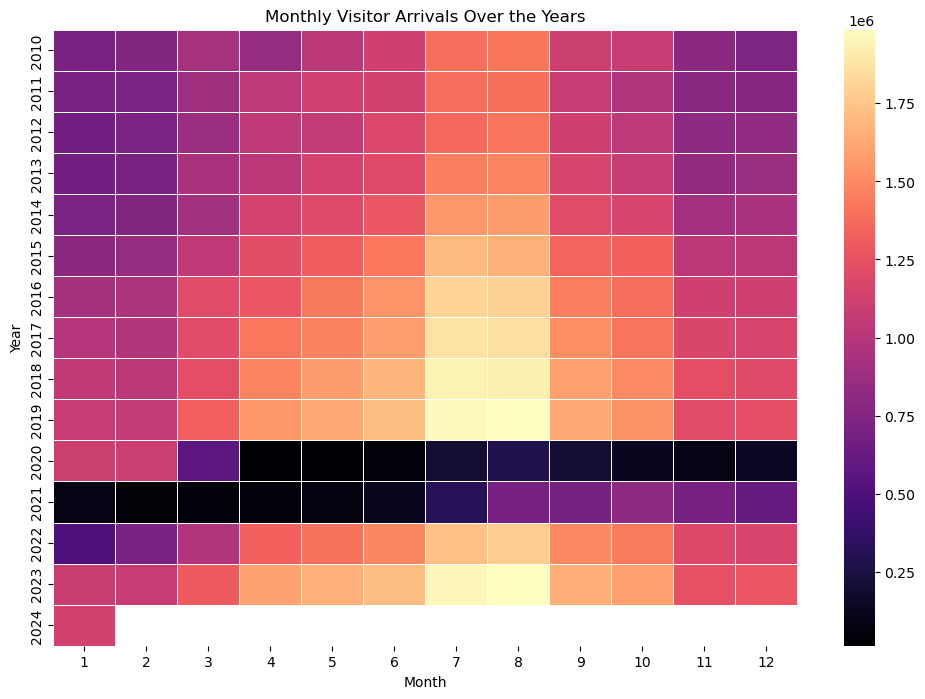

In [50]:
# Pivot the DataFrame to create a heatmap to visualise the change in total visitors over time
heatmap_data = visitors_df.pivot_table(index='Year', columns='Month', values='Visitors', aggfunc='sum')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='magma', annot=False, fmt='d', linewidths=.5)
plt.title('Monthly Visitor Arrivals Over the Years')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

seaborn.pydata.org. (2012). seaborn.heatmap — seaborn 0.10.1 documentation. [online] Available at: https://seaborn.pydata.org/generated/seaborn.heatmap.html.

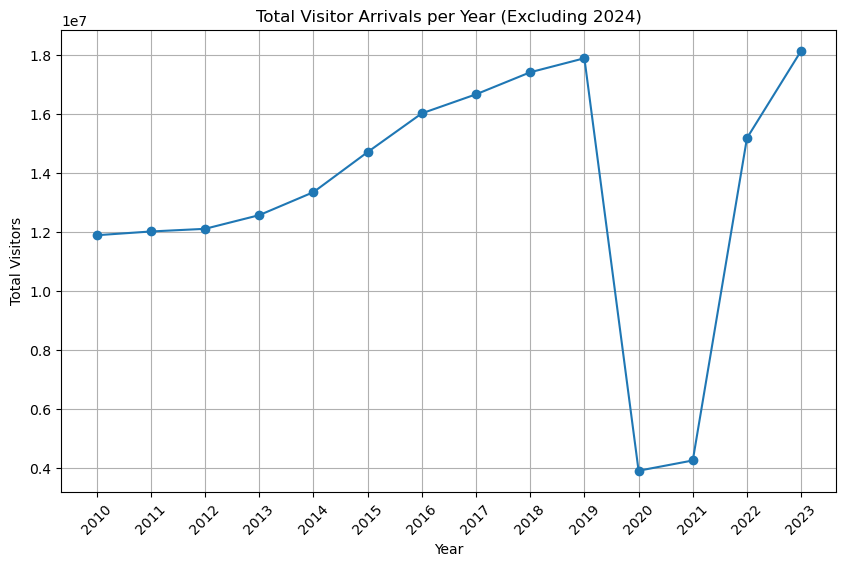

In [51]:
#exclude 2024 for lineplot as there is only 1 month collected and this will distort graph
monthly_visitors_filtered = monthly_visitors[monthly_visitors.index < 2024]

# Plot total visitors per year
plt.figure(figsize=(10, 6))
plt.plot(monthly_visitors_filtered.index, monthly_visitors_filtered['Total'], marker='o', linestyle='-')
plt.title('Total Visitor Arrivals per Year (Excluding 2024)')

#label axes
plt.xlabel('Year')
plt.ylabel('Total Visitors')

#rotate x axis for easy visability
plt.xticks(monthly_visitors_filtered.index, rotation=45) 

#include grid for easy reading of values
plt.grid(True)

#show graph
plt.show()

In [52]:
#store country categories
countries = ["Great Britain","Spain","United States","France","Germany","Netherlands","Italy","Poland","Portugal","United Arab Emirates", "Switzerland","Portugal"]

# Create a Function to Quickly Access Visitor Numbers for Each Year

# Visualise Total Visitors from Each Country in the Dataset 

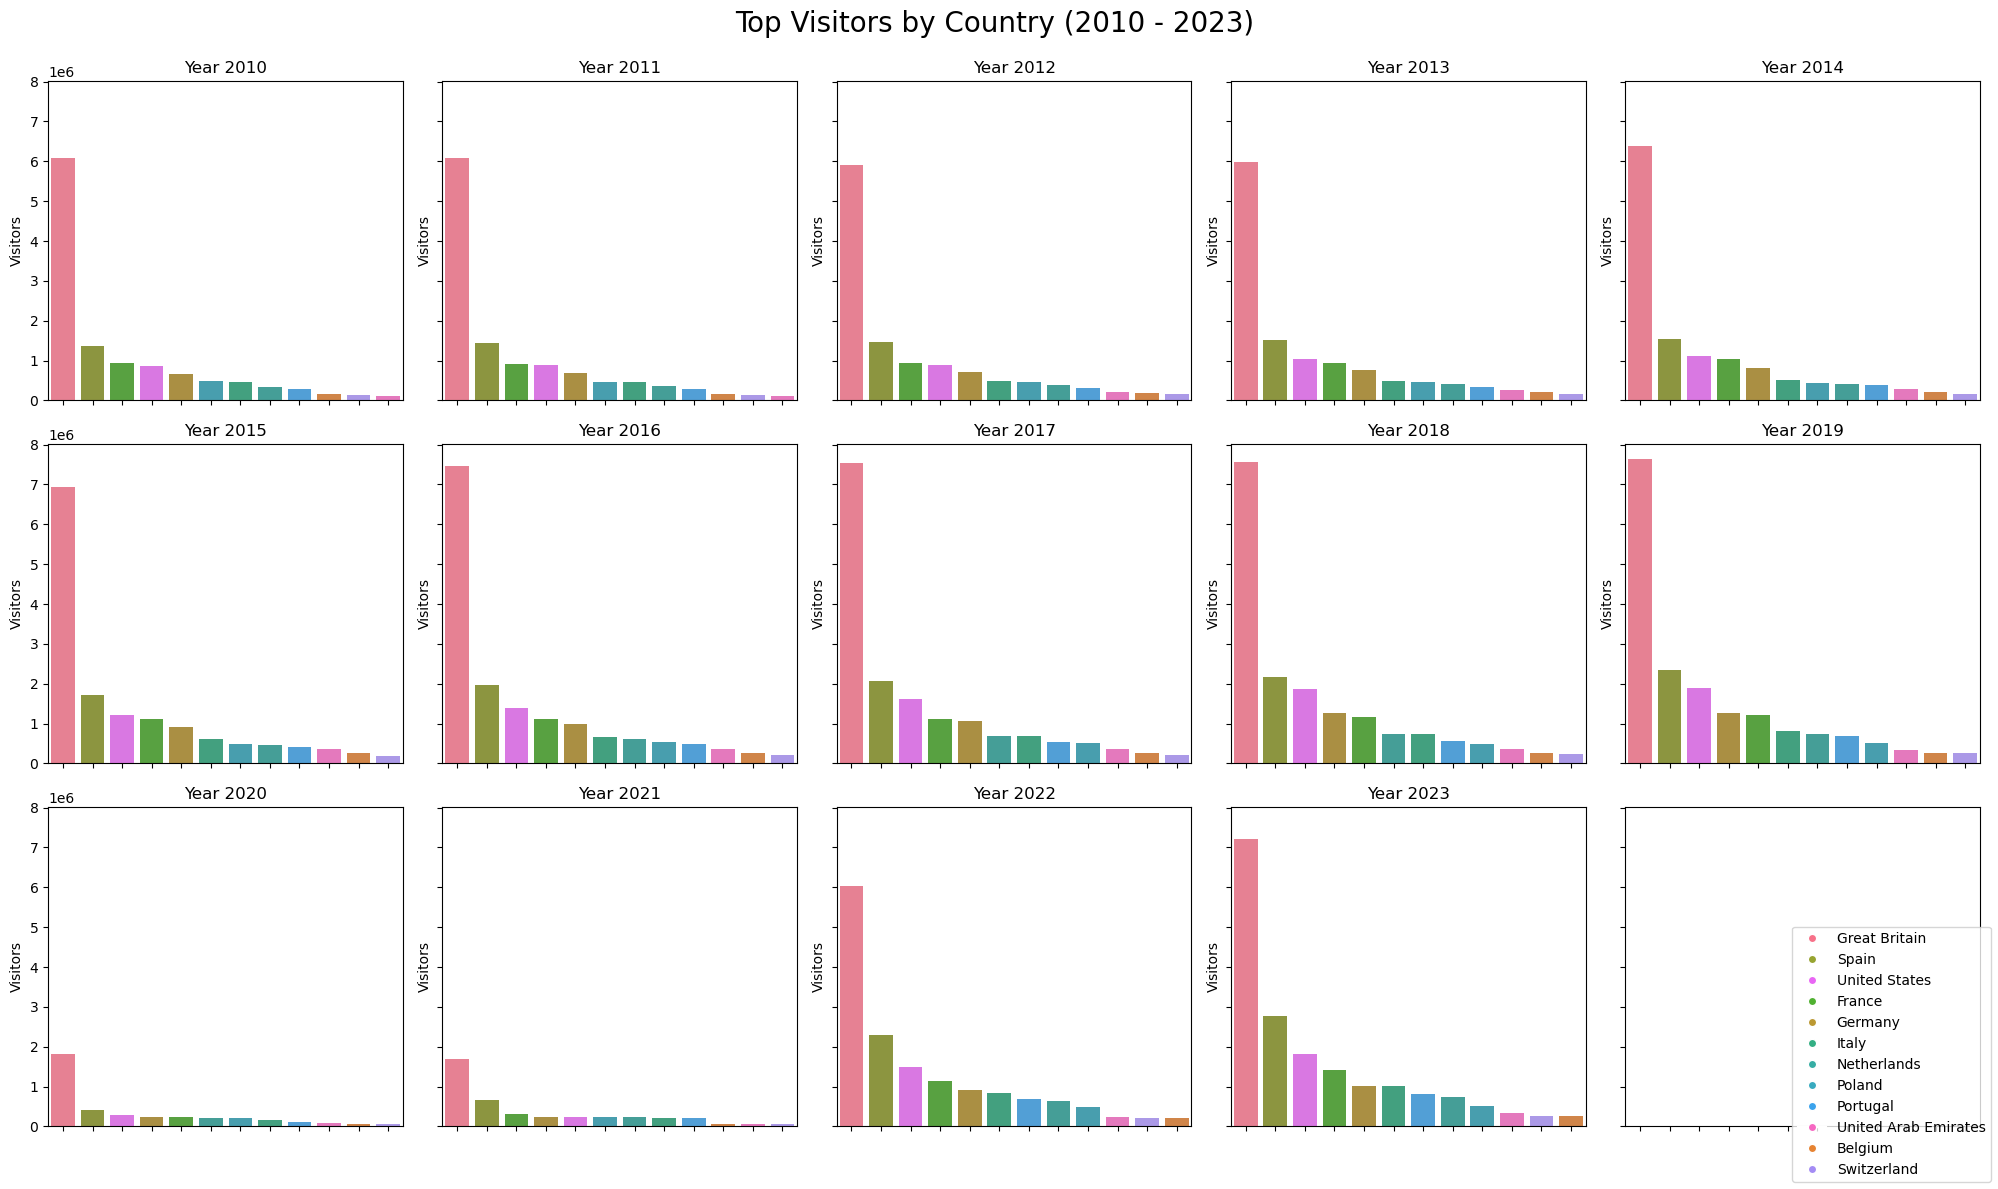

In [53]:
#create a subplot to visualise all the arrivals from each country over time
# Define the figure and axes
fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharex=True, sharey=True)

# create a dictionary to store country to color mappings
country_color_map = {}

# create a dictionary to store the total visitors for each country
country_visitors = {}

# assign colors
all_countries = visitors_df['Country'].unique()
color_palette = sns.color_palette("husl", len(all_countries))
for country, color in zip(all_countries, color_palette):
    country_color_map[country] = color
    
# Run over each year from 2010 to 2023
for i, year in enumerate(range(2010, 2024)):
    # Filter DataFrame for the current year
    year_df = visitors_df[visitors_df['Year'] == year]


    # Group by country and sum the visitors
    top_year_df = year_df.groupby('Country')['Visitors'].sum().reset_index().sort_values("Visitors", ascending=False)[:12]
    
    # Update the total visitors for each country
    for country, visitors in zip(top_year_df['Country'], top_year_df['Visitors']):
        if country not in country_visitors:
            country_visitors[country] = visitors
        else:
            country_visitors[country] += visitors
    
    # Sort the dataframe by number of visitors
    top_year_df = top_year_df.sort_values(by='Visitors', ascending=False)
    
    # Plot the top visitors for the current year
    sns.barplot(x="Country", y="Visitors", data=top_year_df, ax=axes[i // 5, i % 5], order=top_year_df['Country'], palette=[country_color_map[country] for country in top_year_df['Country']])
    
    # Set title for the subplot
    axes[i // 5, i % 5].set_title(f"Year {year}")
    axes[i // 5, i % 5].set_xlabel('')
    
    # Rotate x-axis labels for better readability
    axes[i // 5, i % 5].tick_params(axis='x', rotation=45)
    
    # Remove x-axis labels
    axes[i // 5, i % 5].set_xticklabels([])

# Sort legend handles and labels based on total visitors
sorted_legend_handles = sorted(country_color_map.items(), key=lambda x: country_visitors.get(x[0], 0), reverse=True)
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=country) for country, color in sorted_legend_handles]

# Add the legend to the bottom right of the figure
fig.legend(handles=legend_handles, loc='lower right')

# Adjust spacing between subplots and increase space at the top
plt.tight_layout(rect=[0, 0.03, 1, 0.95])



# Name subplot
plt.suptitle('Top Visitors by Country (2010 - 2023)', fontsize=20)

plt.show()


matplotlib.org. (2012). matplotlib.pyplot.subplots — Matplotlib 3.6.0 documentation. [online] Available at: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html.

Mckinney, W. (2013). Python for data analysis. Beijing: O’reilly.

# Let's zoom in to view the exact figures from 2010 and 2019

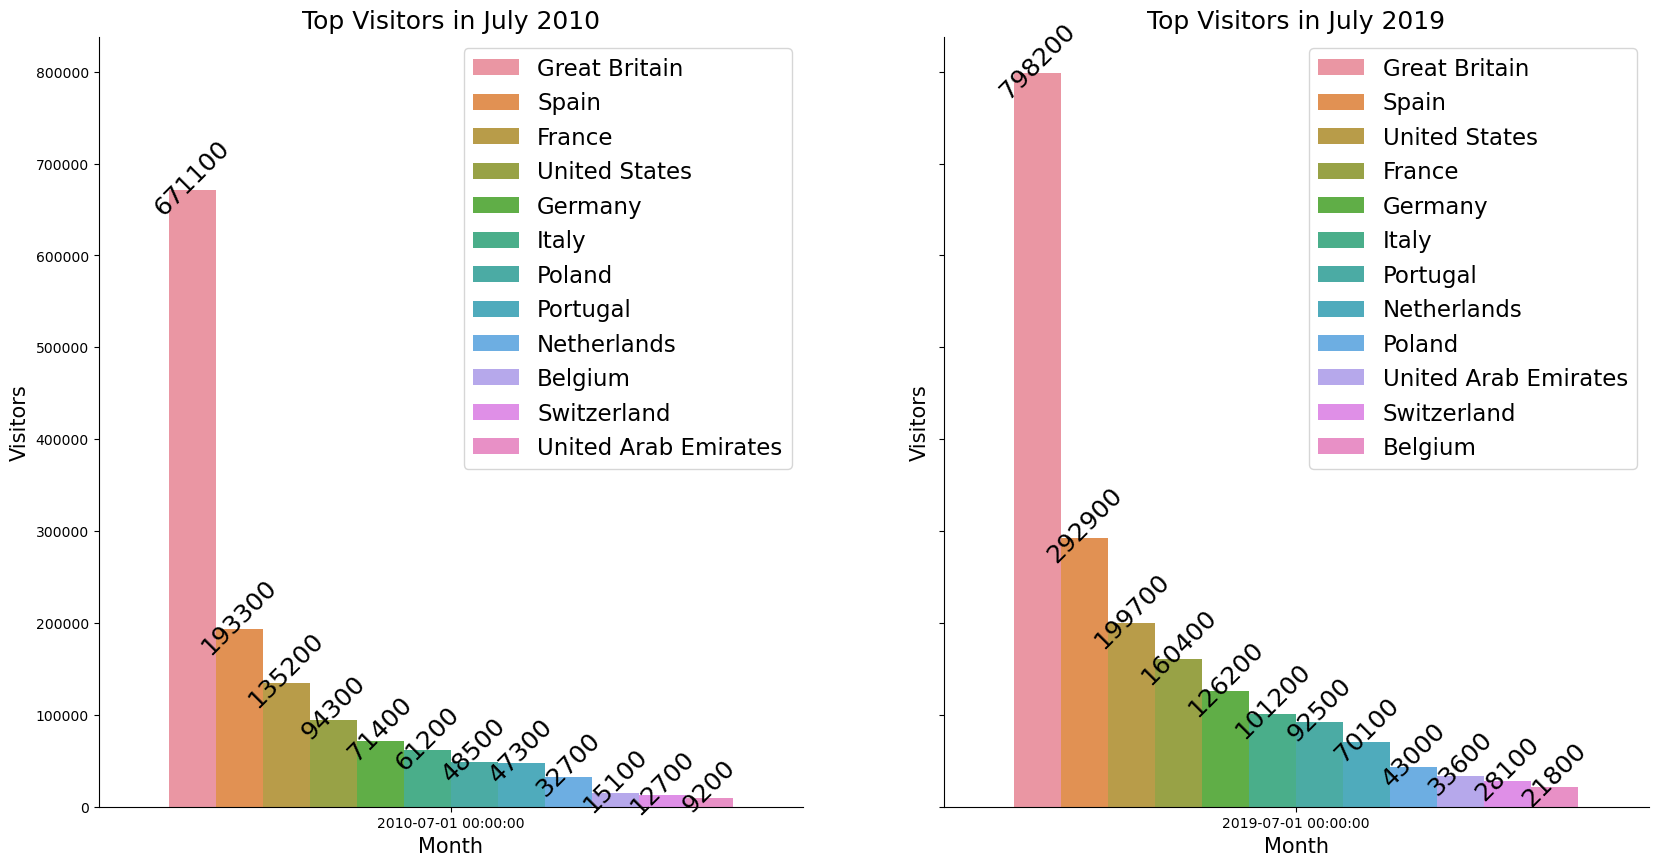

In [54]:
# Filter data for January 2019 and rank from largest to smallest
Visitors_July19 = visitors_df[visitors_df['Date'] == "2019-07-01"]
top_Visitors_July19 = Visitors_July19.sort_values(["Visitors"], ascending=False).head(12)

# Filter data for July 2010 and rank
Visitors_July10 = visitors_df[visitors_df['Date'] == "2010-07-01"]
top_Visitors_July10 = Visitors_July10.sort_values(["Visitors"], ascending=False).head(12)

# Create the bar plots for each date
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
sns.despine()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})



# Plot for July 2010
sns.barplot(x="Date", y="Visitors", data=top_Visitors_July10, hue='Country', ax=axs[0])
for p in axs[0].patches:
    axs[0].annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points', rotation = 45)
    
# Plot for July 2019
sns.barplot(x="Date", y="Visitors", data=top_Visitors_July19, hue='Country', ax=axs[1])
for p in axs[1].patches:
    axs[1].annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',rotation = 45)
    


axs[1].set_ylabel(ylabel='Visitors', fontsize=15)
axs[1].set_xlabel(xlabel='Month', fontsize=15)
axs[1].set_title('Top Visitors in July 2019')
axs[1].legend()


axs[0].set_ylabel(ylabel='Visitors', fontsize=15)
axs[0].set_xlabel(xlabel='Month', fontsize=15)
axs[0].set_title('Top Visitors in July 2010')
axs[0].legend()


plt.show()

seaborn.pydata.org. (2012a). Overview of seaborn plotting functions — seaborn 0.12.0 documentation. [online] Available at: https://seaborn.pydata.org/tutorial/function_overview.html.

In [55]:
#function to get total visitors from each year for a selected country
def get_visitors_by_country_year_with_total(visitors_df):
   
    
    # Prompt user for country name
    country_name = input("Enter country name: ")
    
    # Filter DataFrame based on input
    country_df = visitors_df[visitors_df['Country'] == country_name]
    
    # Check if country is in dataset
    if country_df.empty:
        print(f"No data found for {country_name}.")
        return
    
    # Aggregate visitors by year for the selected country
    visitors_by_year = country_df.groupby('Year')['Visitors'].sum().reset_index()
    
    # Calculate sum visitors from the country for total years
    total_visitors_all_years = country_df['Visitors'].sum()
    
    # Display the yearly data
    print(f"Yearly visitors data for {country_name}:")
    print(visitors_by_year)
    
    # Display the total sum of visitors across all years
    print(f"\nTotal visitors from {country_name} across all years: {total_visitors_all_years}")

# Call the function with the visitors_df DataFrame
get_visitors_by_country_year_with_total(visitors_df)

Enter country name: Great Britain
Yearly visitors data for Great Britain:
    Year   Visitors
0   2010  6086500.0
1   2011  6074700.0
2   2012  5904300.0
3   2013  5987900.0
4   2014  6392800.0
5   2015  6934800.0
6   2016  7464600.0
7   2017  7527600.0
8   2018  7573000.0
9   2019  7627600.0
10  2020  1808600.0
11  2021  1693200.0
12  2022  6026400.0
13  2023  7217800.0
14  2024   463200.0

Total visitors from Great Britain across all years: 84783000.0


In [56]:
def calculate_percentage_increase(visitors_df, year1, year2):
    # Check year1 < year2

    # Get a list of all unique countries
    countries = visitors_df['Country'].unique()

    for country_name in countries:
        # Filter DataFrame for year and countries
        selected_data = visitors_df[(visitors_df['Country'] == country_name) & 
                                    (visitors_df['Year'].isin([year1, year2]))]

        # Aggregate visitors by year for the selected country
        visitors_by_year = selected_data.groupby('Year')['Visitors'].sum()

        # Calculate visitors for each year
        visitors_year1 = visitors_by_year.get(year1, 0)
        visitors_year2 = visitors_by_year.get(year2, 0)

        # Calculate percentage increase
        percentage_increase = ((visitors_year2 - visitors_year1) / visitors_year1) * 100

        # Display the result
        print(f"Visitors from {country_name} increased by {percentage_increase:.2f}% from {year1} to {year2}.")


In [57]:
calculate_percentage_increase(visitors_df, 2010, 2019)

Visitors from Great Britain increased by 25.32% from 2010 to 2019.
Visitors from Belgium increased by 55.49% from 2010 to 2019.
Visitors from Germany increased by 88.00% from 2010 to 2019.
Visitors from Spain increased by 70.96% from 2010 to 2019.
Visitors from France increased by 28.14% from 2010 to 2019.
Visitors from Italy increased by 77.46% from 2010 to 2019.
Visitors from Netherlands increased by 122.50% from 2010 to 2019.
Visitors from Poland increased by 5.70% from 2010 to 2019.
Visitors from Portugal increased by 132.14% from 2010 to 2019.
Visitors from Switzerland increased by 95.26% from 2010 to 2019.
Visitors from United States increased by 117.19% from 2010 to 2019.
Visitors from United Arab Emirates increased by 234.24% from 2010 to 2019.


In [58]:
calculate_percentage_increase(visitors_df, 2019, 2020)

Visitors from Great Britain increased by -76.29% from 2019 to 2020.
Visitors from Belgium increased by -76.33% from 2019 to 2020.
Visitors from Germany increased by -80.20% from 2019 to 2020.
Visitors from Spain increased by -82.33% from 2019 to 2020.
Visitors from France increased by -80.30% from 2019 to 2020.
Visitors from Italy increased by -79.67% from 2019 to 2020.
Visitors from Netherlands increased by -70.82% from 2019 to 2020.
Visitors from Poland increased by -59.50% from 2019 to 2020.
Visitors from Portugal increased by -82.24% from 2019 to 2020.
Visitors from Switzerland increased by -78.51% from 2019 to 2020.
Visitors from United States increased by -85.19% from 2019 to 2020.
Visitors from United Arab Emirates increased by -72.62% from 2019 to 2020.


# How do Visitor Numbers Change Seasonally?

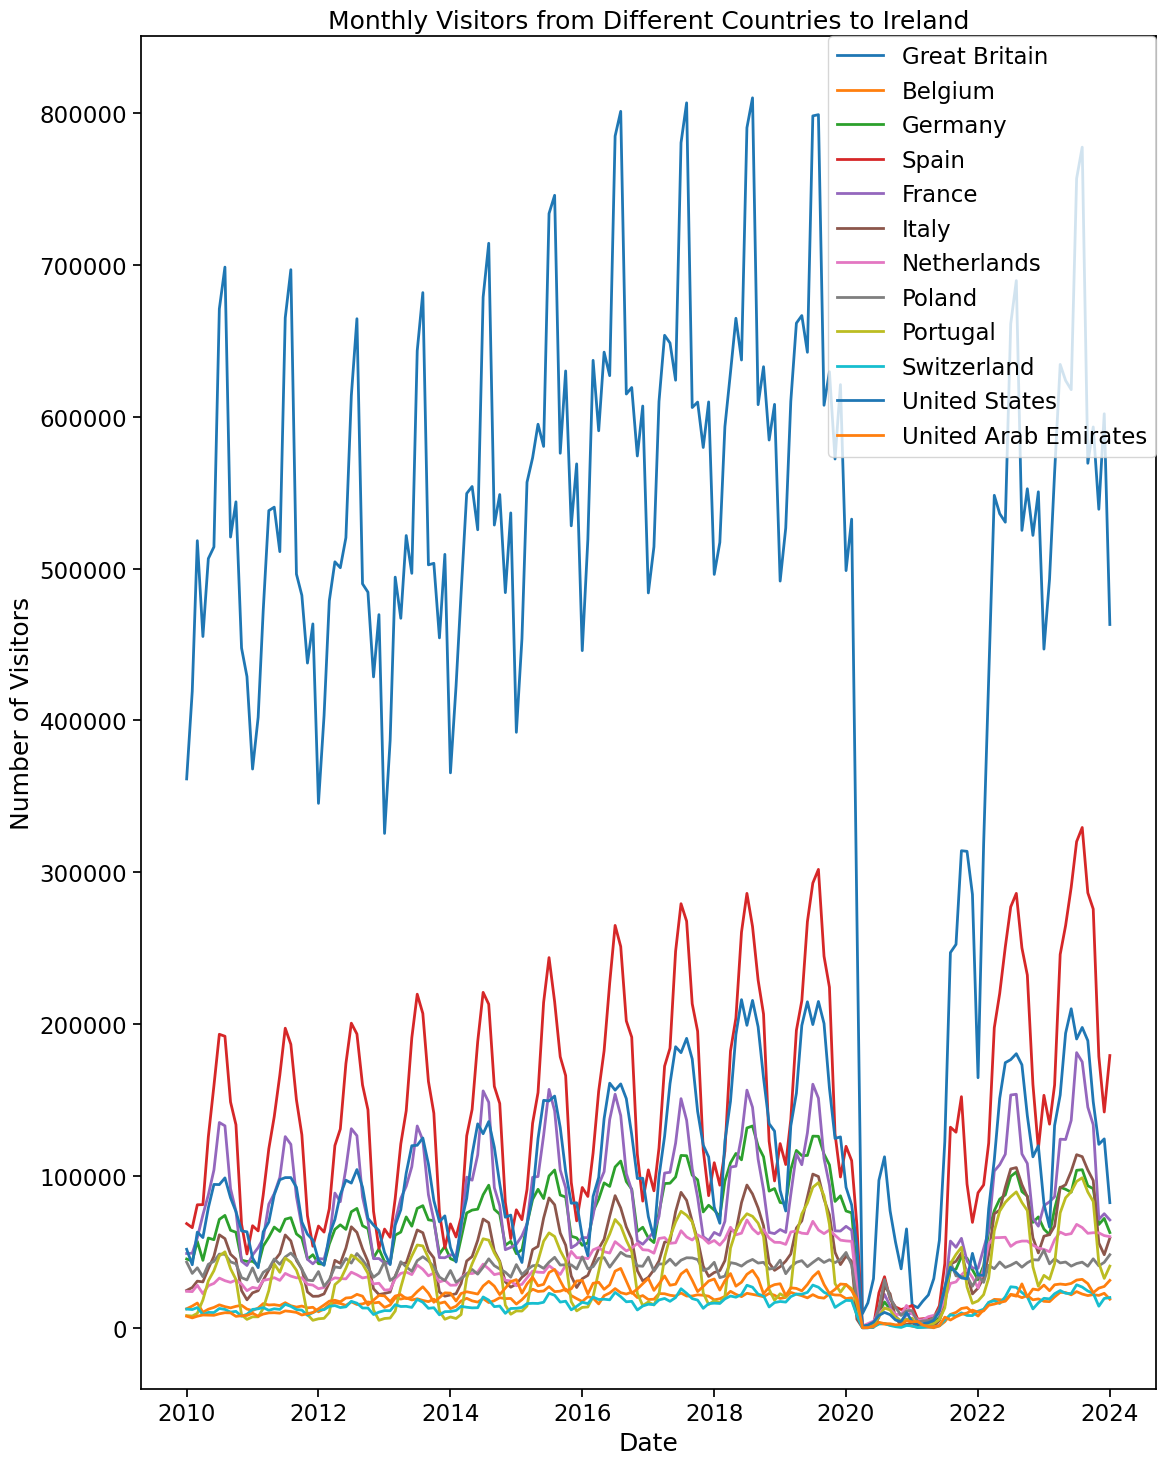

In [59]:
#create a lineplot to visualise montlhy visitors from each individual country

#assign figure size
plt.figure(figsize=(12, 15))

#create a loop to plot each country
for country in visitors_df["Country"].unique():
    country_data = visitors_df[visitors_df["Country"] == country]
    plt.plot(country_data["Date"], country_data["Visitors"], label=country)
    
#x and y labels
plt.xlabel("Date")
plt.ylabel("Number of Visitors")

#set title
plt.title("Monthly Visitors from Different Countries to Ireland")

#include legend
plt.legend(title='Country', fontsize='5', title_fontsize='8')

#move legend out of way
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0.)
plt.tight_layout()

#show plot
plt.show()

In [60]:
#function to filter countries
def filter_countries_by_arrivals(dataframe, countries_list):
     return dataframe[dataframe['Country'].isin(countries_list)]

In [61]:
#filtering for top 3 countries for a neater and easier to read output
top_countries = ["Great Britain","Spain","United States"]

top_arrivals = filter_countries_by_arrivals(visitors_df, top_countries)

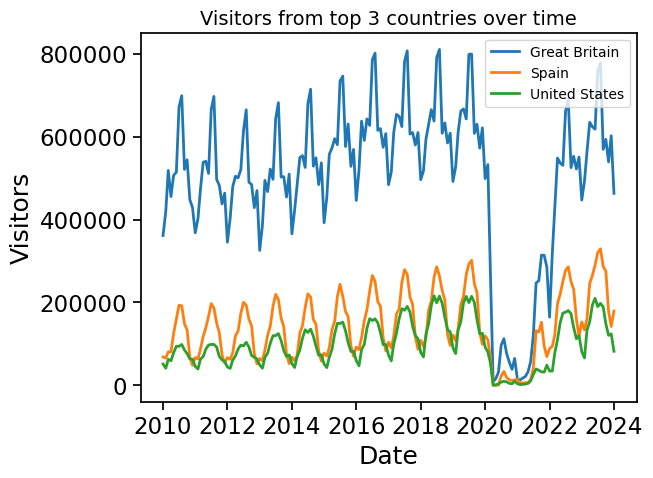

In [62]:
#plot top 3 arrivals
sns.lineplot(data=top_arrivals, x="Date", y="Visitors", hue="Country")

#include legend
plt.legend(fontsize='10', title_fontsize='12')

#graph title
plt.title('Visitors from top 3 countries over time', fontsize=14)

plt.show()

# Statistics

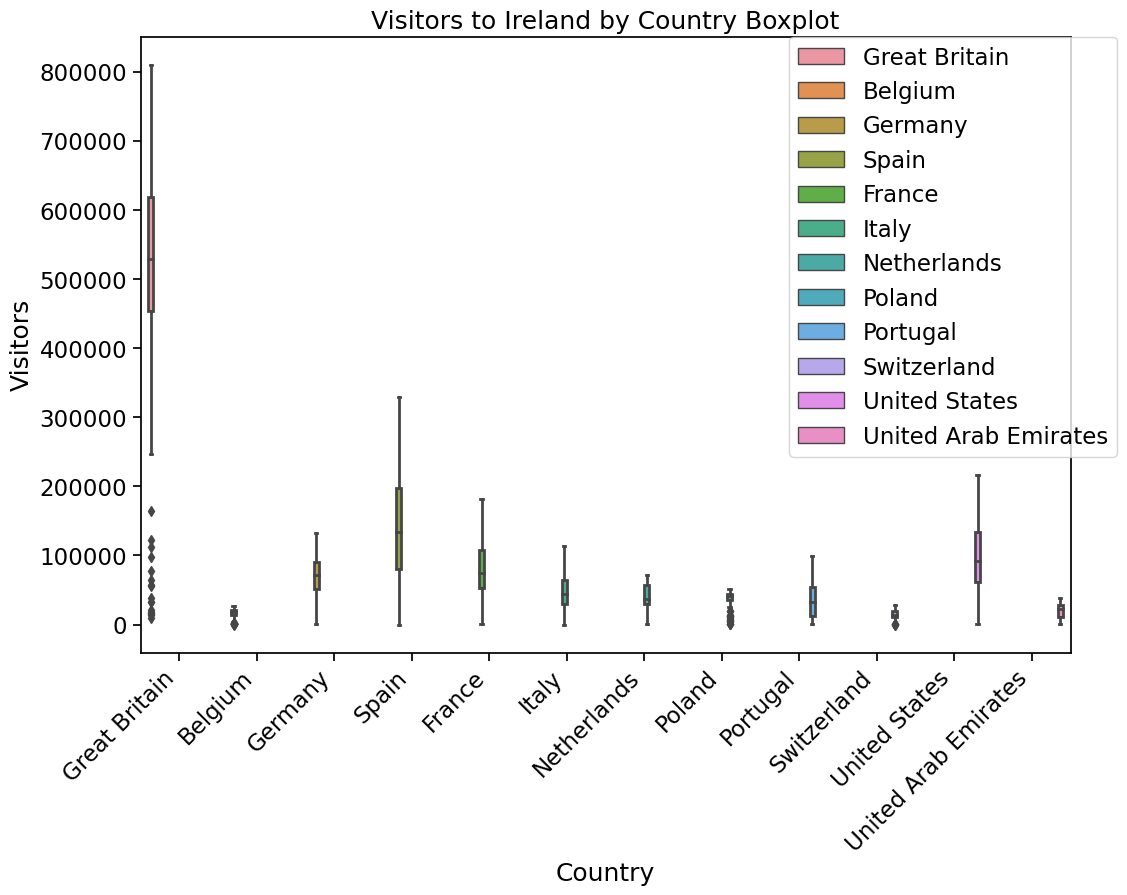

In [63]:
#create a boxplot to observe data spread
plt.figure(figsize=(12, 8))  

#assign data values
ax= sns.boxplot(x='Country', y='Visitors', data=visitors_df, hue='Country')

#label Graph
plt.title('Visitors to Ireland by Country Boxplot')

#rotate axis for easy reading
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

#insert legend
plt.legend(title='Country', fontsize='x-small', title_fontsize='small')


plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1), borderaxespad=0.)


plt.show()


In [64]:
# Calculate the IQR for 'Great Britain'
GB_df = visitors_df[visitors_df['Country'].isin(['Great Britain'])]
Q1 = GB_df['Visitors'].quantile(0.25)
Q3 = GB_df['Visitors'].quantile(0.75)
IQR = Q3 - Q1

#calculate upper and lower band
lower_bound = Q1 - 1.5* IQR
upper_bound = Q3 + 1.5* IQR

#show results
print(Q1, Q3, IQR)

#filter dataframe for outliers
GB_outliers = GB_df[(GB_df['Visitors'] < lower_bound) | (GB_df['Visitors'] > upper_bound)]




453900.0 617900.0 164000.0


In [65]:
#print outliers
print(GB_outliers)

           Date        Country  Visitors  Month  Year   Latitude  Longitude
1476 2020-04-01  Great Britain    9300.0      4  2020  54.315159  -1.918153
1488 2020-05-01  Great Britain   16400.0      5  2020  54.315159  -1.918153
1500 2020-06-01  Great Britain   32300.0      6  2020  54.315159  -1.918153
1512 2020-07-01  Great Britain   97100.0      7  2020  54.315159  -1.918153
1524 2020-08-01  Great Britain  112600.0      8  2020  54.315159  -1.918153
1536 2020-09-01  Great Britain   77000.0      9  2020  54.315159  -1.918153
1548 2020-10-01  Great Britain   56400.0     10  2020  54.315159  -1.918153
1560 2020-11-01  Great Britain   38800.0     11  2020  54.315159  -1.918153
1572 2020-12-01  Great Britain   65100.0     12  2020  54.315159  -1.918153
1584 2021-01-01  Great Britain   15100.0      1  2021  54.315159  -1.918153
1596 2021-02-01  Great Britain   13200.0      2  2021  54.315159  -1.918153
1608 2021-03-01  Great Britain   17500.0      3  2021  54.315159  -1.918153
1620 2021-04

# Remove Outlier Months

In [66]:
#Creating new data set removing time period during covid pandemic (also took out march as data was still skewed)
start = 1464 
end = 1739    
df_no_covid = visitors_df.drop(visitors_df.index[start:end+1])

In [67]:
#check updated rows and column count
df_no_covid.shape

(1752, 7)

In [68]:
#inspect statistical properties
df_no_covid.describe()

Date       Visitors        Month         Year  \
count                           1752    1752.000000  1752.000000  1752.000000   
mean   2016-05-09 21:51:46.849314816  103237.500000     6.431507  2015.904110   
min              2010-01-01 00:00:00    4900.000000     1.000000  2010.000000   
25%              2013-01-01 00:00:00   25700.000000     3.000000  2013.000000   
50%              2016-01-16 12:00:00   49650.000000     6.000000  2016.000000   
75%              2019-02-01 00:00:00   95325.000000     9.000000  2019.000000   
max              2024-01-01 00:00:00  810100.000000    12.000000  2024.000000   
std                              NaN  150387.580038     3.478725     4.003417   

          Latitude    Longitude  
count  1752.000000  1752.000000  
mean     44.949270     0.111668  
min      24.000249  -100.445882  
25%      39.753339    -2.648110  
50%      46.700958     5.150519  
75%      51.426846    11.004448  
max      54.315159    53.999483  
std       8.174197    33.994032

In [69]:
#Aggregate Data by Date without outliers
aggregated_data = df_no_covid.groupby('Date')['Visitors'].sum().reset_index()

In [70]:
# Locate the row with the maximum value
max = aggregated_data[aggregated_data['Visitors'] == aggregated_data['Visitors'].max()]

# Locate the row with the minimum value
min = aggregated_data[aggregated_data['Visitors'] == aggregated_data['Visitors'].min()]

# Display 
print("Row with the maximum number of visitors:\n", max)
print("\nRow with the minimum number of visitors:\n", min)

Row with the maximum number of visitors:
           Date   Visitors
140 2023-08-01  1985700.0

Row with the minimum number of visitors:
          Date  Visitors
24 2012-01-01  668800.0


## Generate a Boxplot of the Top 3 Arrivals to Examine if Outliers have been Removed and if Data is More Evenly Spread

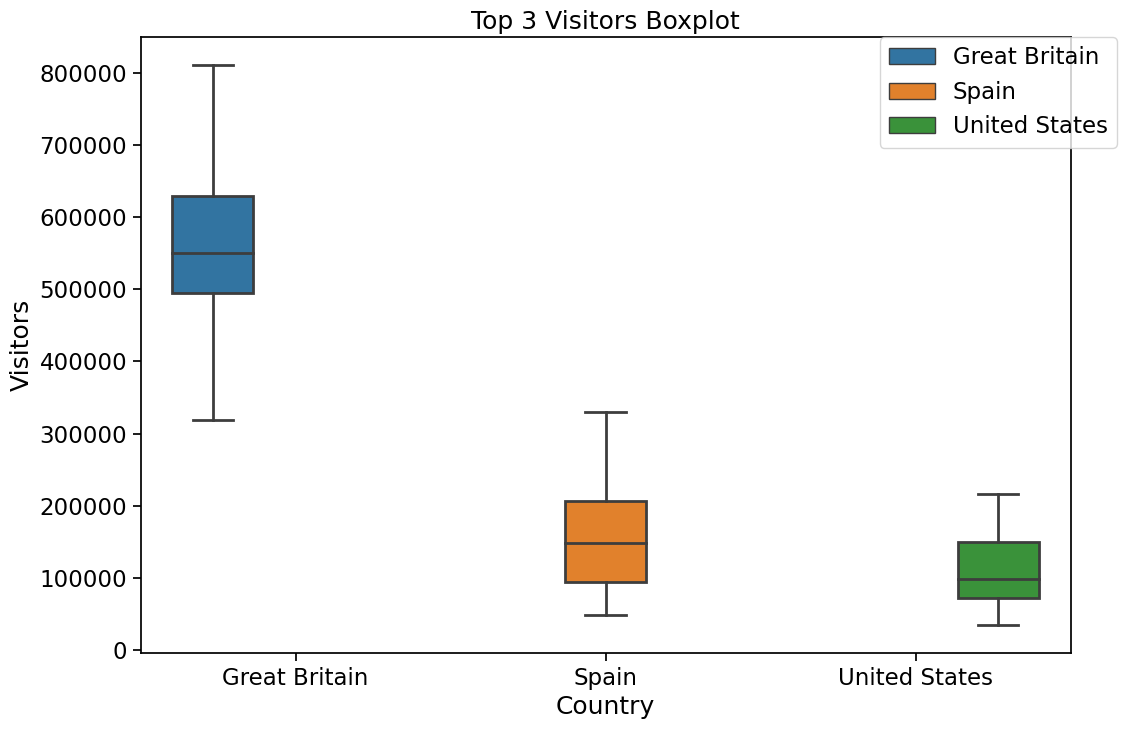

In [71]:
#filter countries to include
top_countries = ["Great Britain","Spain","United States"]

#use function created earlier
top3_nocovid = filter_countries_by_arrivals(df_no_covid, top_countries)

#set plot size
plt.figure(figsize=(12, 8))  

#plot boxplot using seaborn
ax= sns.boxplot(x='Country', y='Visitors', data=top3_nocovid, hue='Country')

#label graph
plt.title('Top 3 Visitors Boxplot')

#insert legend
plt.legend(title='Country', fontsize='x-small', title_fontsize='small')

#set location as to not block data
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

#display
plt.show()


### Calculating the Mean and Median

In [72]:
#check mean monthly arriavls for each country
mean_visitors = df_no_covid.groupby('Month')['Visitors'].mean().reset_index()
mean_visitors

Month       Visitors
0       1   74534.615385
1       2   72925.000000
2       3   89175.694444
3       4  103909.722222
4       5  111450.694444
5       6  118460.416667
6       7  139719.444444
7       8  140903.472222
8       9  113629.861111
9      10  107920.833333
10     11   85587.500000
11     12   85550.694444

In [73]:
#check median monthly arriavls for each country
median_visitors = df_no_covid.groupby('Month')['Visitors'].median().reset_index()  
median_visitors

Month  Visitors
0       1   43700.0
1       2   37900.0
2       3   43450.0
3       4   54650.0
4       5   59250.0
5       6   62150.0
6       7   71450.0
7       8   70850.0
8       9   62100.0
9      10   58700.0
10     11   42800.0
11     12   41300.0

In [74]:
#calculate total visitor mean
aggregated_data["Visitors"].mean()

1238850.0

In [75]:
#calculate total visitor median
aggregated_data["Visitors"].median()

1204700.0

# Discrete Distriutions

#### I have decided to do my analysis on my data with outliers removed as they  will skew my results

In [76]:
#import distribution libraries
from scipy.stats import binom_test
from scipy.stats import poisson
from scipy.stats import binom
from scipy.stats import norm

## Binomial Distribution

In [77]:
#calculate total arrivals
sum_arrivals = df_no_covid['Visitors'].sum()
sum_arrivals

180872100.0

In [78]:
#calculate total arrivals from Great Britain
sum_Britain=df_no_covid[df_no_covid['Country'] == 'Great Britain']['Visitors'].sum()
sum_Britain

82147800.0

In [79]:
#calculate relative frequency
relative_frequency = sum_Britain/sum_arrivals
relative_frequency

0.4541761830597422

probability that a tourist to Ireland is from GB is 0.4534 excluding covid years

In [80]:
#How many would I expect?
n = 10
p = 0.4534
expected_value = n*p
expected_value

4.534000000000001

In [81]:
#Calculate the probability of 4 of those 10 visitors being from Great Britain

result=binom.pmf(k=3 , n=10 ,p= 0.4534)
result

0.16304713986484853

If I survey 3 passengers at Dublin airport arrivals what is the probability that 1 is from Great Britain?

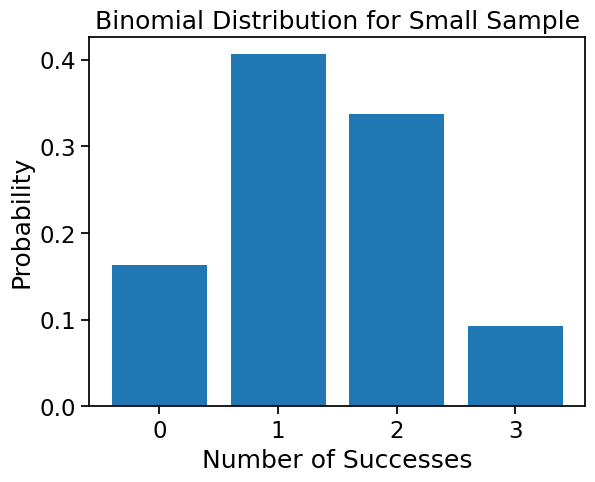

In [82]:
#Sample size is 3 visitors
size = 3  
#The probabilty of success (Visitor being from Great Britain) is 0.4534
prob = 0.4534  
#I want to find probability of 1 being from Great Britain
k=1


successes = range(size + 1)

#probability mass function

pmf_values = [binom.pmf(k, size, prob) for k in successes]

# Plot the PMF as a bar chart
import matplotlib.pyplot as plt

plt.bar(successes, pmf_values)
plt.title('Binomial Distribution for Small Sample')
plt.xlabel('Number of Successes')
plt.ylabel('Probability')
plt.show()

In [83]:
#Calculate the probability of at least 4 of those 10 visitors being from Great Britain
binom.sf(k = 4, n = 10, p = 0.4534)

0.5044329909952119

## Increasing Sample Size

In [84]:
#prob mass function to calculate probability of 40 out of 100 arrivals being from Great Britain
binom.pmf(k = 40, n = 100, p = 0.4534)

0.04545922318860011

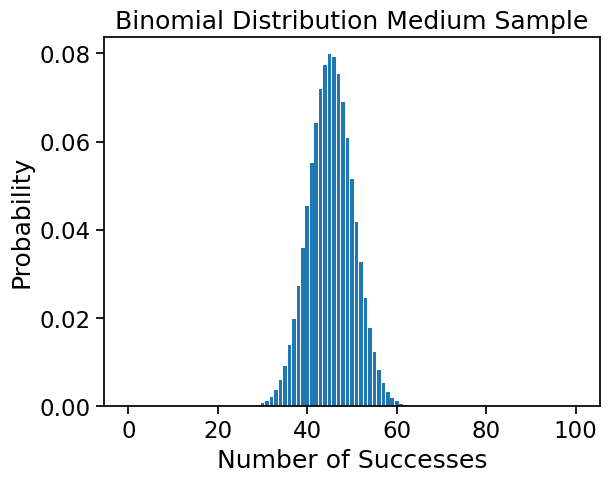

In [85]:
#Sample size is 100 visitors
size = 100  
#The probabilty of success 
prob = 0.4534  
#I want to find probability of 40 being from GB
k=40

successes = range(size + 1)

#probability mass function
sf_values = [binom.pmf(k, size, prob) for k in successes]

# Plot the PMF as a bar chart
import matplotlib.pyplot as plt

plt.bar(successes, sf_values)
plt.title('Binomial Distribution Medium Sample')
plt.xlabel('Number of Successes')
plt.ylabel('Probability')
plt.show()

## Increasing n to 100,000

In [86]:
#Calculate the probability of 40000 of those 100000 visitors being from Great Britain
result=binom.pmf(k=4000 , n=10000 ,p= 0.1273)
result

0.0

Sample size is too big, reduce to 10,000

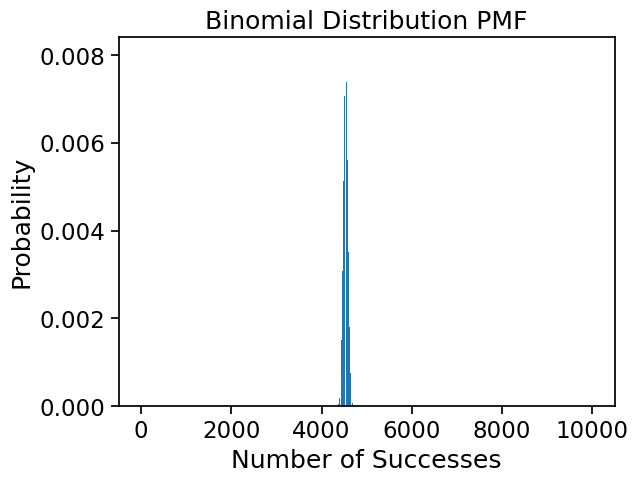

In [87]:
#Sample size = 1000 visitors
size = 10000 
#The probabilty of success (Visitor being from Spain) is 0.4534
prob = 0.4534  
#I want to find probability of 10 being from Spain
k=3000


successes = range(size + 1)

# apply probability mass function
pmf_values = [binom.pmf(k, size, prob) for k in successes]

# Plot the PMF as a bar chart
import matplotlib.pyplot as plt

#label and assign values
plt.bar(successes, pmf_values)
plt.title('Binomial Distribution PMF')
plt.xlabel('Number of Successes')
plt.ylabel('Probability')
plt.show()

# Poisson Distribution

Poisson Distribution is used when looking at events during a fixed period of time or location where there is no defined limit (Iantorno, 2024)

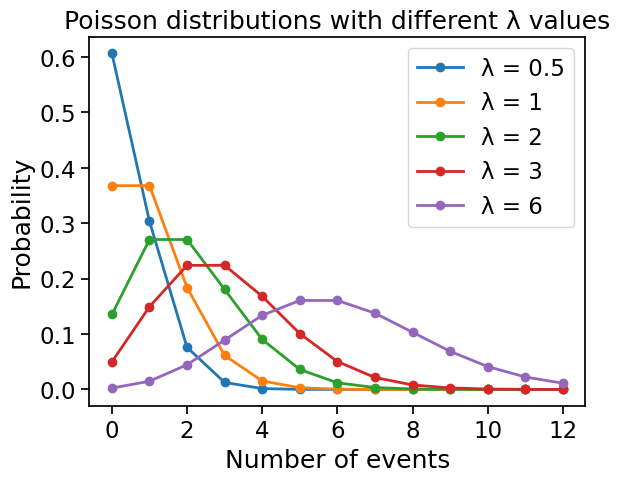

In [88]:
#create graph to visualise how poisson behaves for small samples

# Range of x values I want to plot
x = np.arange(0, 13)

# Different lambda values
lambdas = [0.5, 1, 2, 3, 6]

# create a plot for each lambda
for lam in lambdas:
    pmf = poisson.pmf(x, lam)
    plt.plot(x, pmf, '-o', label=f'λ = {lam}')
    
#label graph
plt.title('Poisson distributions with different λ values')
plt.xlabel('Number of events')
plt.ylabel('Probability')
plt.legend()
plt.show()

Iantorno, M. (2024). Poisson Distribution.

Focusing on my sample I want to investigate the daily and monthly arrivals from Switzerland

In [89]:
# Function to work out average daily arrivals from a country
def calculate_lambda_for_poisson(df_no_covid, user_country):
    # Filter for the specified country's visitors
    country_visitors = visitors_df[visitors_df['Country'] == user_country]
    
    # Calculate the total arrivals for selected country
    total_visitors_from_country = country_visitors['Visitors'].sum()
    
    # Calculate λ for daily arrivals
    lambda_country = total_visitors_from_country / 4442
    
    # Calculate λ for monthly arrivals
    lambda_monthly_country = total_visitors_from_country / 146
    
    return lambda_country , lambda_monthly_country


### Probability of Observing a Specific Number of Visitors from a Given Country:

In [90]:
# User input for country name
user_country = input("Enter the country to calculate the mean number of visitors for: ")

# Calculate daily and monthly λ values using function
lambda_daily_country, lambda_monthly_country = calculate_lambda_for_poisson(df_no_covid, user_country)
print(f"Average daily number of visitors from {user_country}: {lambda_daily_country:.2f}")
print(f"Average monthly number of visitors from {user_country}: {lambda_monthly_country:.2f}")

# User input for daily arrivals 
user_arrivals = int(input("Enter the number of daily arrivals to check the probability for: "))

# calculate probability of observing 'user_arrivals' visitors
probability_daily = poisson.pmf(user_arrivals, lambda_daily_country)
print(f"Probability of observing {user_arrivals} arrivals in a day from {user_country}: {probability_daily:.4f}")

# User input for  monthly arrivals
user_monthly_arrivals = int(input("Enter the number of monthly arrivals to check the probability for: "))

# calculate probability of observing 'user_monthly_arrivals' visitors
probability_monthly = poisson.pmf(user_monthly_arrivals, lambda_monthly_country)
print(f"Probability of observing {user_monthly_arrivals} arrivals in a month from {user_country}: {probability_monthly:.4f}")

Enter the country to calculate the mean number of visitors for: Switzerland
Average daily number of visitors from Switzerland: 560.58
Average monthly number of visitors from Switzerland: 17055.48
Enter the number of daily arrivals to check the probability for: 550
Probability of observing 550 arrivals in a day from Switzerland: 0.0154
Enter the number of monthly arrivals to check the probability for: 17000
Probability of observing 17000 arrivals in a month from Switzerland: 0.0028


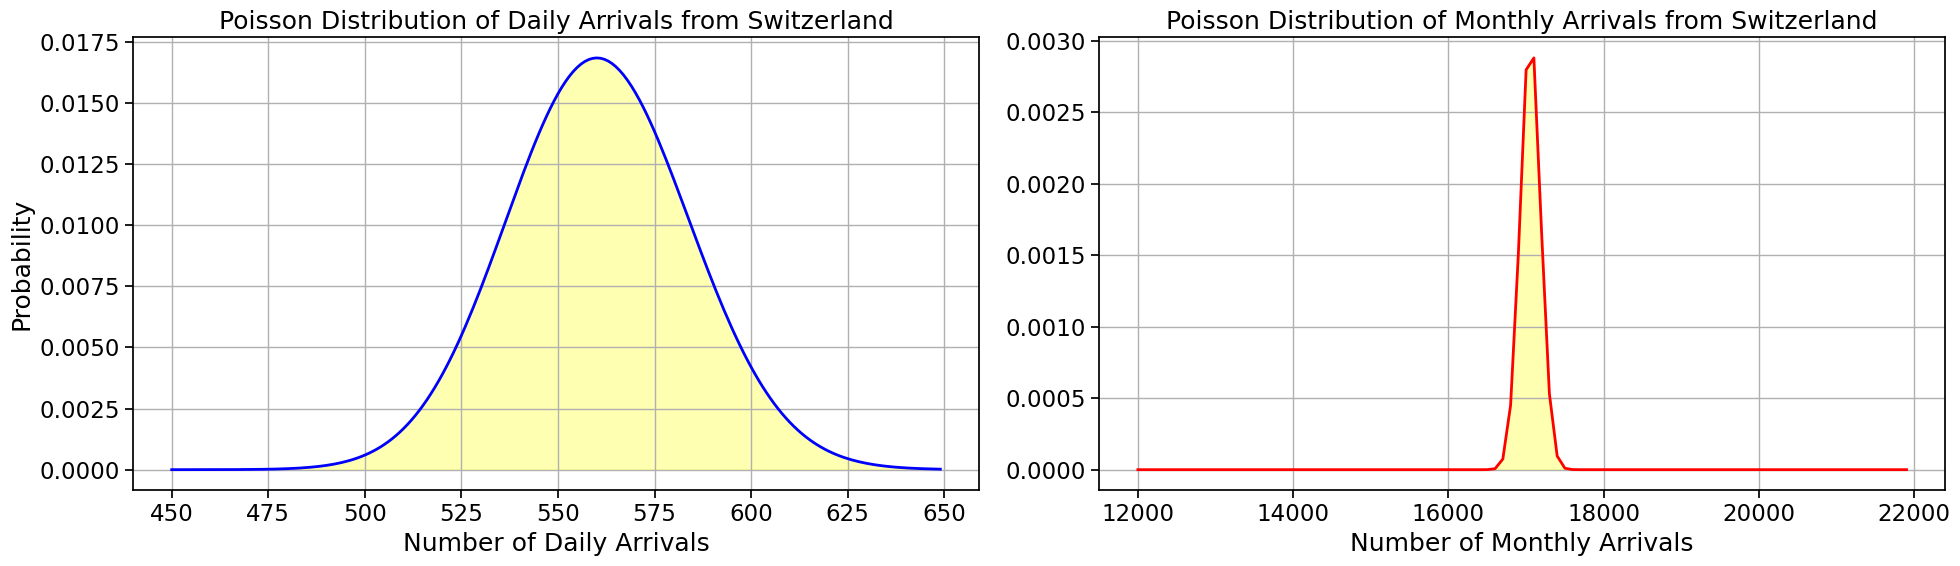

In [91]:
# create subplot to compare daily and monthly
fig, axes = plt.subplots(1, 2, figsize=(20, 6)) # 1 row, 2 columns

# First subplot: Daily arrivals

# Range I want to plot
daily_arrivals_range = np.arange(user_arrivals - 100, user_arrivals + 100, 1)

# Calculating Poisson probabilities for the range of daily arrivals
prob_daily_arrivals = poisson.pmf(daily_arrivals_range, lambda_daily_country)

axes[0].plot(daily_arrivals_range, prob_daily_arrivals, linestyle='-', color='blue')
axes[0].set_title(f'Poisson Distribution of Daily Arrivals from {user_country}')
axes[0].set_xlabel('Number of Daily Arrivals')
axes[0].set_ylabel('Probability')
axes[0].grid(True)

# Second subplot: Monthly arrivals

# Range of monthly arrivals to visualize
monthly_arrivals_range = np.arange(user_monthly_arrivals - 5000, user_monthly_arrivals + 5000, 100)

# Calculating Poisson probabilities for the range of monthly arrivals
prob_monthly_arrivals = poisson.pmf(monthly_arrivals_range, lambda_monthly_country)

axes[1].plot(monthly_arrivals_range, prob_monthly_arrivals, linestyle='-', color='red')
axes[1].set_title(f'Poisson Distribution of Monthly Arrivals from {user_country}')
axes[1].set_xlabel('Number of Monthly Arrivals')
axes[1].grid(True)

# highlight area under curve where 0<prob<1
axes[1].fill_between(monthly_arrivals_range, prob_monthly_arrivals, where=(prob_monthly_arrivals > 0) & (prob_monthly_arrivals < 1), color='yellow', alpha=0.3)
axes[0].fill_between(daily_arrivals_range, prob_daily_arrivals, where=(prob_daily_arrivals > 0) & (prob_daily_arrivals < 1), color='yellow', alpha=0.3)


plt.tight_layout()
plt.show()

Iantorno, M. (2024). Poisson Distribution.

### Probability of Observing More Than a Specific Number of Visitors from a Given Country:

In [92]:
# User input for country name
user_country = input("Enter the country to calculate the mean number of visitors for: ")

# Calculating λ for daily and monthly averages using function
lambda_daily_country, lambda_monthly_country = calculate_lambda_for_poisson(df_no_covid, user_country)
print(f"Average daily number of visitors from {user_country}: {lambda_daily_country:.2f}")
print(f"Average monthly number of visitors from {user_country}: {lambda_monthly_country:.2f}")

# User input for daily arrivals
user_arrivals = int(input("Enter the number of daily arrivals to check the probability for: "))

# Calculate the probability of observing 'user_arrivals' visitors
probability_daily = poisson.sf(user_arrivals, lambda_daily_country)
print(f"Probability of observing more than {user_arrivals} arrivals in a day from {user_country}: {probability_daily:.4f}")

# User input for  monthly arrivals 
user_monthly_arrivals = int(input("Enter the number of monthly arrivals to check the probability for: "))

# Calculate the probability of observing 'user_monthly_arrivals' visitors in a month
probability_monthly = poisson.sf(user_monthly_arrivals, lambda_monthly_country)
print(f"Probability of observing more than {user_monthly_arrivals} arrivals in a month from {user_country}: {probability_monthly:.4f}")

Enter the country to calculate the mean number of visitors for: Switzerland
Average daily number of visitors from Switzerland: 560.58
Average monthly number of visitors from Switzerland: 17055.48
Enter the number of daily arrivals to check the probability for: 550
Probability of observing more than 550 arrivals in a day from Switzerland: 0.6628
Enter the number of monthly arrivals to check the probability for: 17000
Probability of observing more than 17000 arrivals in a month from Switzerland: 0.6627


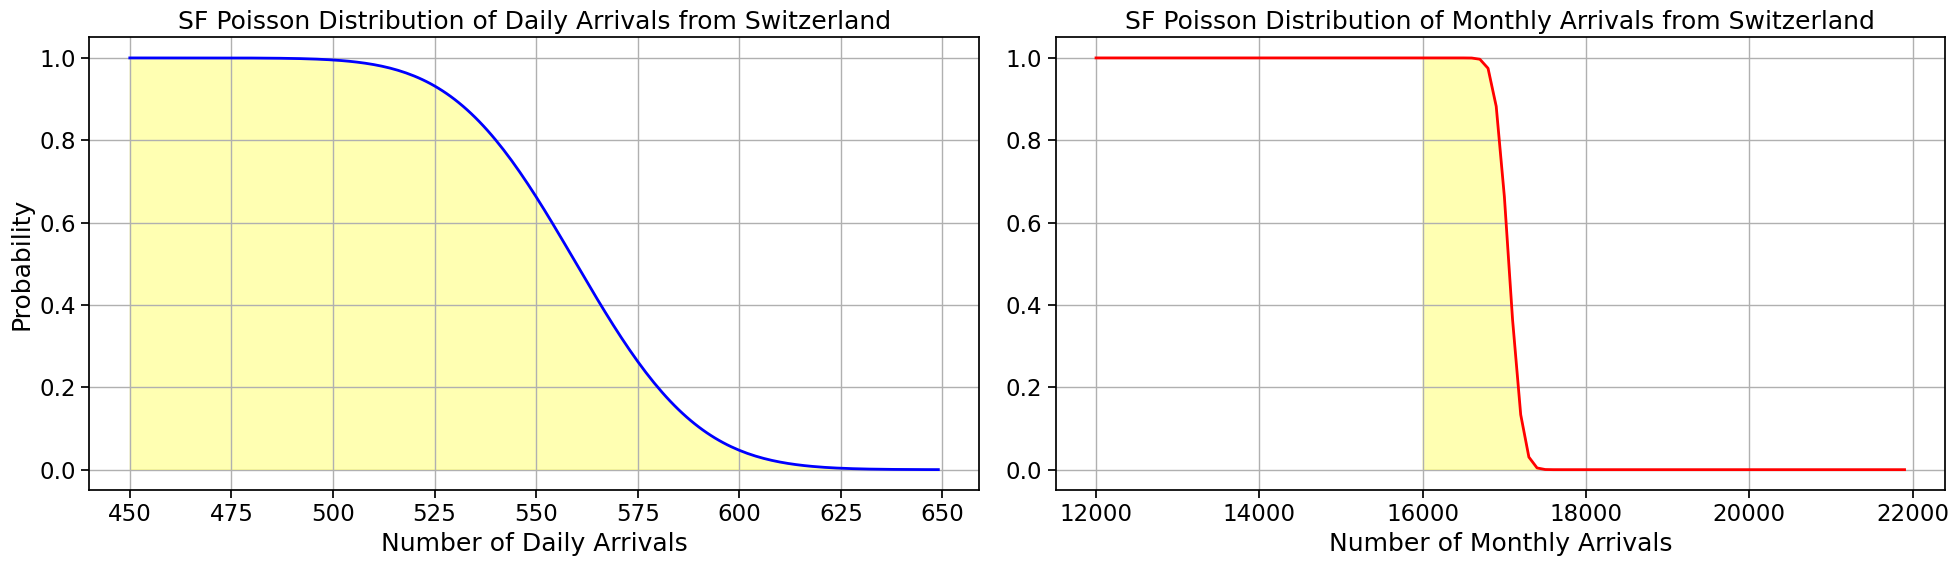

In [93]:
# Setup for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 6)) # 1 row, 2 columns

# First subplot: Daily arrivals

# Range of daily arrivals to visualize
daily_arrivals_range = np.arange(user_arrivals - 100, user_arrivals + 100, 1)

# Calculating Poisson probabilities for the range of daily arrivals
prob_daily_arrivals = poisson.sf(daily_arrivals_range, lambda_daily_country)

axes[0].plot(daily_arrivals_range, prob_daily_arrivals, linestyle='-', color='blue')
axes[0].set_title(f'SF Poisson Distribution of Daily Arrivals from {user_country}')
axes[0].set_xlabel('Number of Daily Arrivals')
axes[0].set_ylabel('Probability')
axes[0].grid(True)

# Second subplot: Monthly arrivals

# Range of monthly arrivals to visualize
monthly_arrivals_range = np.arange(user_monthly_arrivals - 5000, user_monthly_arrivals + 5000, 100)

# Calculating Poisson probabilities for the range of monthly arrivals
prob_monthly_arrivals = poisson.sf(monthly_arrivals_range, lambda_monthly_country)

axes[1].plot(monthly_arrivals_range, prob_monthly_arrivals, linestyle='-', color='red')
axes[1].set_title(f'SF Poisson Distribution of Monthly Arrivals from {user_country}')
axes[1].set_xlabel('Number of Monthly Arrivals')
axes[1].grid(True)

# Correctly using fill_between for highlighting areas
axes[1].fill_between(monthly_arrivals_range, prob_monthly_arrivals, where=(prob_monthly_arrivals > 0) & (prob_monthly_arrivals < 1), color='yellow', alpha=0.3)
axes[0].fill_between(daily_arrivals_range, prob_daily_arrivals, where=(prob_daily_arrivals > 0) & (prob_daily_arrivals < 1), color='yellow', alpha=0.3)

# Adjust layout

# Adjust layout
plt.tight_layout()
plt.show()

### Probability of Observing Less Than a Specific Number of Visitors from a Given Country:

In [94]:
# User input for country name
user_country = input("Enter the country to calculate the mean number of visitors for: ")

# Calculating λ for daily and monthly averages using function
lambda_daily_country, lambda_monthly_country = calculate_lambda_for_poisson(df_no_covid, user_country)
print(f"Average daily number of visitors from {user_country}: {lambda_daily_country:.2f}")
print(f"Average monthly number of visitors from {user_country}: {lambda_monthly_country:.2f}")

# User input for daily arrivals 
user_arrivals = int(input("Enter the number of daily arrivals to check the probability for: "))

# Calculate the probability of observing 'user_arrivals' visitors
probability_daily = poisson.cdf(user_arrivals, lambda_daily_country)
print(f"Probability of observing less than or equal to {user_arrivals} arrivals in a day from {user_country}: {probability_daily:.4f}")

# User input for  monthly arrivals
user_monthly_arrivals = int(input("Enter the number of monthly arrivals to check the probability for: "))

# Calculate the probability of observing 'user_monthly_arrivals' visitors in a month
probability_monthly = poisson.cdf(user_monthly_arrivals, lambda_monthly_country)
print(f"Probability of observing less than or equal to {user_monthly_arrivals} arrivals in a month from {user_country}: {probability_monthly:.4f}")

Enter the country to calculate the mean number of visitors for: Switzerland
Average daily number of visitors from Switzerland: 560.58
Average monthly number of visitors from Switzerland: 17055.48
Enter the number of daily arrivals to check the probability for: 550
Probability of observing less than or equal to 550 arrivals in a day from Switzerland: 0.3372
Enter the number of monthly arrivals to check the probability for: 17000
Probability of observing less than or equal to 17000 arrivals in a month from Switzerland: 0.3373


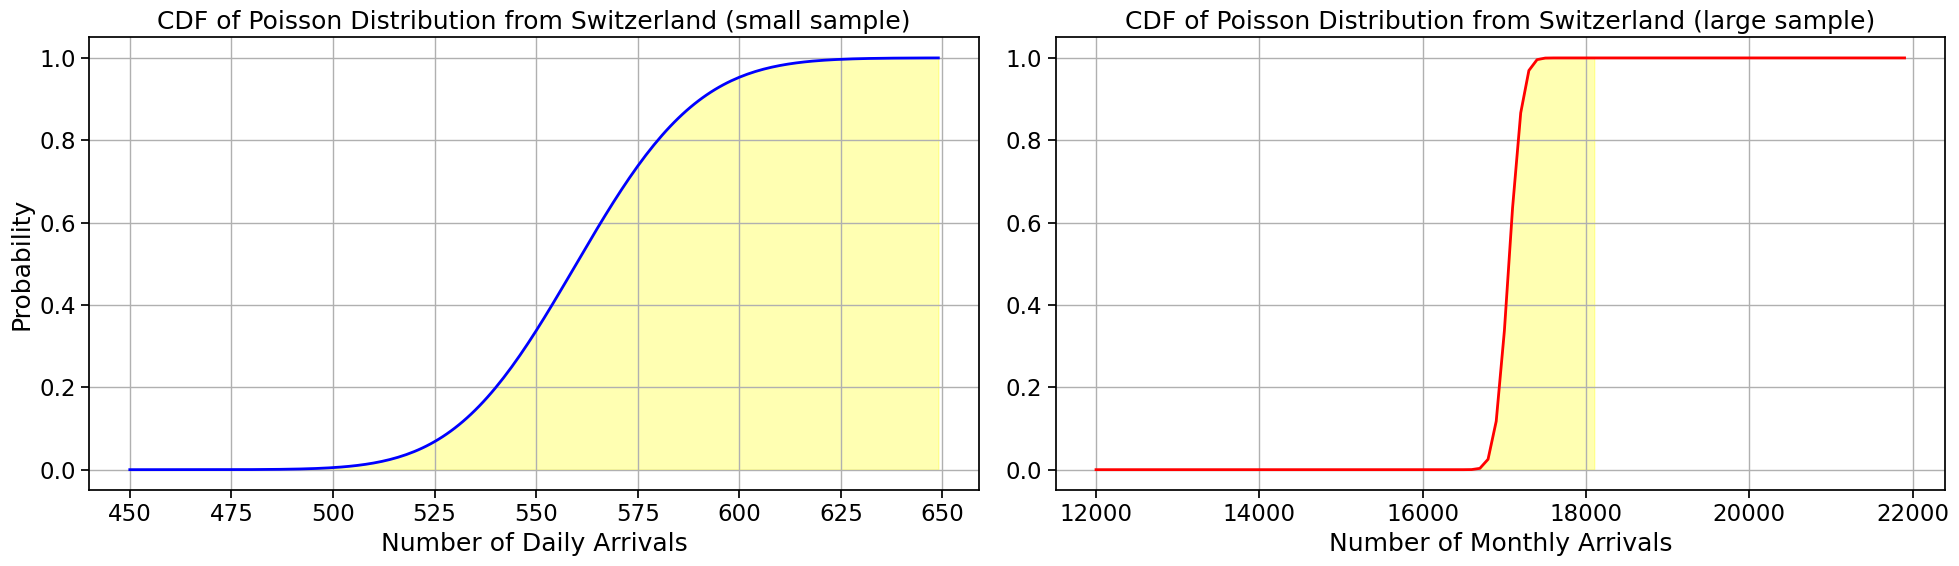

In [95]:
# Setup to compare plots
fig, axes = plt.subplots(1, 2, figsize=(20, 6)) # 1 row, 2 columns

# First subplot: Daily arrivals

# Range I want to visulaise
daily_arrivals_range = np.arange(user_arrivals - 100, user_arrivals + 100, 1)

# Calculating Poisson probabilities for daily arrivals
prob_daily_arrivals = poisson.cdf(daily_arrivals_range, lambda_daily_country)

axes[0].plot(daily_arrivals_range, prob_daily_arrivals, linestyle='-', color='blue')
axes[0].set_title(f'CDF of Poisson Distribution from {user_country} (small sample)')
axes[0].set_xlabel('Number of Daily Arrivals')
axes[0].set_ylabel('Probability')
axes[0].grid(True)

# Second subplot: Monthly arrivals

# Range of monthly arrivals to visualize
monthly_arrivals_range = np.arange(user_monthly_arrivals - 5000, user_monthly_arrivals + 5000, 100)

# Calculating Poisson probabilities for monthly arrivals
prob_monthly_arrivals = poisson.cdf(monthly_arrivals_range, lambda_monthly_country)

axes[1].plot(monthly_arrivals_range, prob_monthly_arrivals, linestyle='-', color='red')
axes[1].set_title(f'CDF of Poisson Distribution from {user_country} (large sample)')
axes[1].set_xlabel('Number of Monthly Arrivals')
axes[1].grid(True)

# Show possible probability range
axes[1].fill_between(monthly_arrivals_range, prob_monthly_arrivals, where=(prob_monthly_arrivals > 0) & (prob_monthly_arrivals < 1), color='yellow', alpha=0.3)
axes[0].fill_between(daily_arrivals_range, prob_daily_arrivals, where=(prob_daily_arrivals > 0) & (prob_daily_arrivals < 1), color='yellow', alpha=0.3)


# show graph
plt.tight_layout()
plt.show()

# Normal Distribution

In [96]:
#import new data frame to obtain continuous data, taken from CSO Open Data Platform
expend_df = pd.read_csv("GB_money.csv")

In [97]:
#inspect columns and rows
expend_df.head(19)

Statistic Label       Month  \
0   Expenditure of Overnight Foreign Visitors  2023 April   
1   Expenditure of Overnight Foreign Visitors  2023 April   
2   Expenditure of Overnight Foreign Visitors  2023 April   
3   Expenditure of Overnight Foreign Visitors  2023 April   
4   Expenditure of Overnight Foreign Visitors  2023 April   
5   Expenditure of Overnight Foreign Visitors    2023 May   
6   Expenditure of Overnight Foreign Visitors    2023 May   
7   Expenditure of Overnight Foreign Visitors    2023 May   
8   Expenditure of Overnight Foreign Visitors    2023 May   
9   Expenditure of Overnight Foreign Visitors    2023 May   
10  Expenditure of Overnight Foreign Visitors   2023 June   
11  Expenditure of Overnight Foreign Visitors   2023 June   
12  Expenditure of Overnight Foreign Visitors   2023 June   
13  Expenditure of Overnight Foreign Visitors   2023 June   
14  Expenditure of Overnight Foreign Visitors   2023 June   
15  Expenditure of Overnight Foreign Visitors   2023 July   
16  Expenditure of Overnight Foreign Visitors   2023 July   
17  Expenditure of Overnight Foreign Visitors   2023 July   
18  Expenditure of Overnight Foreign Visitors   2023 July   

                                    Residency        Expenditure Type  \
0   Great Britain (England, Scotland & Wales)                    Fare   
1   Great Britain (England, Scotland & Wales)             Prepayments   
2   Great Britain (England, Scotland & Wales)           Accommodation   
3   Great Britain (England, Scotland & Wales)  Day-to-Day Expenditure   
4   Great Britain (England, Scotland & Wales)  All Travel Expenditure   
5   Great Britain (England, Scotland & Wales)                    Fare   
6   Great Britain (England, Scotland & Wales)             Prepayments   
7   Great Britain (England, Scotland & Wales)           Accommodation   
8   Great Britain (England, Scotland & Wales)  Day-to-Day Expenditure   
9   Great Britain (England, Scotland & Wales)  All Travel Expenditure   
10  Great Britain (England, Scotland & Wales)                    Fare   
11  Great Britain (England, Scotland & Wales)             Prepayments   
12  Great Britain (England, Scotland & Wales)           Accommodation   
13  Great Britain (England, Scotland & Wales)  Day-to-Day Expenditure   
14  Great Britain (England, Scotland & Wales)  All Travel Expenditure   
15  Great Britain (England, Scotland & Wales)                    Fare   
16  Great Britain (England, Scotland & Wales)             Prepayments   
17  Great Britain (England, Scotland & Wales)           Accommodation   
18  Great Britain (England, Scotland & Wales)  Day-to-Day Expenditure   

            UNIT  VALUE  
0   Euro Million   28.3  
1   Euro Million    1.9  
2   Euro Million   27.9  
3   Euro Million   57.8  
4   Euro Million  116.0  
5   Euro Million   28.8  
6   Euro Million    3.2  
7   Euro Million   35.5  
8   Euro Million   56.5  
9   Euro Million  123.9  
10  Euro Million   37.5  
11  Euro Million    5.9  
12  Euro Million   44.8  
13  Euro Million   67.8  
14  Euro Million  156.0  
15  Euro Million   41.1  
16  Euro Million    3.2  
17  Euro Million   41.3  
18  Euro Million   85.8

In [98]:
#check for NaN values
expend_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Statistic Label   150 non-null    object 
 1   Month             150 non-null    object 
 2   Residency         150 non-null    object 
 3   Expenditure Type  150 non-null    object 
 4   UNIT              150 non-null    object 
 5   VALUE             150 non-null    float64
dtypes: float64(1), object(5)
memory usage: 7.2+ KB


In [99]:
#only want total each month
expend_df=expend_df[expend_df["Expenditure Type"]=="All Travel Expenditure"]

In [100]:
#insert new column by mulltiplyinh "Value" by a million
expend_df["Total Spent"] = expend_df["VALUE"] * 1000000

In [101]:
#drop columns no longer required
expend_df=expend_df.drop(columns=["UNIT","VALUE"])

In [102]:
#isolate rows from df_no_covid which can be stiched to this df
GB_money_df = df_no_covid[(df_no_covid['Country'] == 'Great Britain') & (df_no_covid['Year'].isin([2023, 2024]))]


In [103]:
#function to filter df
def filter_by_months(df, months_to_filter):
    return df[df['Month'].isin(months_to_filter)]
months_to_filter = [1, 5, 6, 7, 8, 9, 10, 11,12] 

#apply to dataset
GB_money_df = filter_by_months(GB_money_df, months_to_filter)

In [104]:
#need to remove January from 2023
GB_money_df = GB_money_df[(GB_df['Date'] != "2023-01-01")]

C:\Users\a-ldrumm\AppData\Local\Temp\ipykernel_48544\2410393214.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [105]:
#reset index
GB_money_df = GB_money_df.reset_index(drop=True)

In [106]:
expend_df = expend_df.reset_index(drop=True)

In [107]:
# Merge GB_df with expend_df based on row numbers
merged_df = pd.merge(GB_money_df, expend_df[['Total Spent']], left_index=True, right_index=True, suffixes=('_GB', '_expend'))

# Assign the 'Total Spent' column to GB_df
GB_money_df['Total Spent'] = merged_df['Total Spent']

pandas.pydata.org. (2024a). pandas.DataFrame.merge — pandas 1.4.2 documentation. [online] Available at: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html.

In [108]:
#create new column: expenditure per visitor
GB_money_df['Average expenditure per visitor'] = GB_money_df['Total Spent'] / GB_money_df['Visitors']

In [109]:
GB_money_df.head(12)

Date        Country  Visitors  Month  Year   Latitude  Longitude  \
0 2023-05-01  Great Britain  623900.0      5  2023  54.315159  -1.918153   
1 2023-06-01  Great Britain  617900.0      6  2023  54.315159  -1.918153   
2 2023-07-01  Great Britain  757000.0      7  2023  54.315159  -1.918153   
3 2023-08-01  Great Britain  777600.0      8  2023  54.315159  -1.918153   
4 2023-09-01  Great Britain  569400.0      9  2023  54.315159  -1.918153   
5 2023-10-01  Great Britain  593300.0     10  2023  54.315159  -1.918153   
6 2023-11-01  Great Britain  539100.0     11  2023  54.315159  -1.918153   
7 2023-12-01  Great Britain  602000.0     12  2023  54.315159  -1.918153   
8 2024-01-01  Great Britain  463200.0      1  2024  54.315159  -1.918153   

   Total Spent  Average expenditure per visitor  
0  116000000.0                       185.927232  
1  123900000.0                       200.517883  
2  156000000.0                       206.076618  
3  171300000.0                       220.293210  
4  176600000.0                       310.151036  
5  159500000.0                       268.835328  
6  122100000.0                       226.488592  
7  103300000.0                       171.594684  
8  107700000.0                       232.512953

In [110]:
#calculate average expenditure per person
average= GB_money_df["Average expenditure per visitor"].mean()

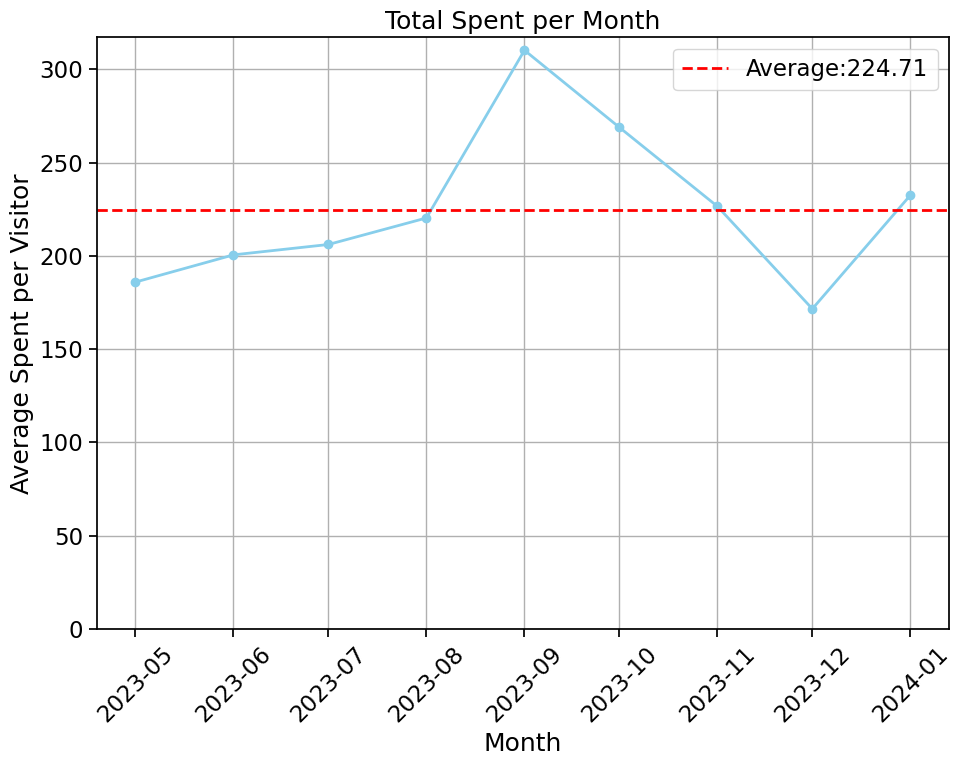

In [111]:
average = 224.71
#assign figure size
plt.figure(figsize=(10, 8))
#plot graph
plt.plot(GB_money_df['Date'], GB_money_df['Average expenditure per visitor'], marker='o', color='skyblue', linestyle='-')
plt.axhline(y=average, color='red', linestyle='--', label='Average:224.71')
plt.ylim(bottom=0)
plt.xlabel('Month')
plt.ylabel('Average Spent per Visitor')
plt.title('Total Spent per Month')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)

# Show plot
plt.tight_layout()
plt.legend()
plt.show()

In [112]:
#checking value of standard deviation (sigma)
GB_money_df.describe()

Date       Visitors      Month         Year  \
count                    9       9.000000   9.000000     9.000000   
mean   2023-08-31 13:20:00  615933.333333   7.666667  2023.111111   
min    2023-05-01 00:00:00  463200.000000   1.000000  2023.000000   
25%    2023-07-01 00:00:00  569400.000000   6.000000  2023.000000   
50%    2023-09-01 00:00:00  602000.000000   8.000000  2023.000000   
75%    2023-11-01 00:00:00  623900.000000  10.000000  2023.000000   
max    2024-01-01 00:00:00  777600.000000  12.000000  2024.000000   
std                    NaN   98872.291366   3.391165     0.333333   

           Latitude     Longitude   Total Spent  \
count  9.000000e+00  9.000000e+00  9.000000e+00   
mean   5.431516e+01 -1.918153e+00  1.373778e+08   
min    5.431516e+01 -1.918153e+00  1.033000e+08   
25%    5.431516e+01 -1.918153e+00  1.160000e+08   
50%    5.431516e+01 -1.918153e+00  1.239000e+08   
75%    5.431516e+01 -1.918153e+00  1.595000e+08   
max    5.431516e+01 -1.918153e+00  1.766000e+08   
std    1.507289e-14  2.355139e-16  2.837123e+07   

       Average expenditure per visitor  
count                         9.000000  
mean                        224.710837  
min                         171.594684  
25%                         200.517883  
50%                         220.293210  
75%                         232.512953  
max                         310.151036  
std                          42.703299

Probability of spending 250 euro or less: 0.723244049332014


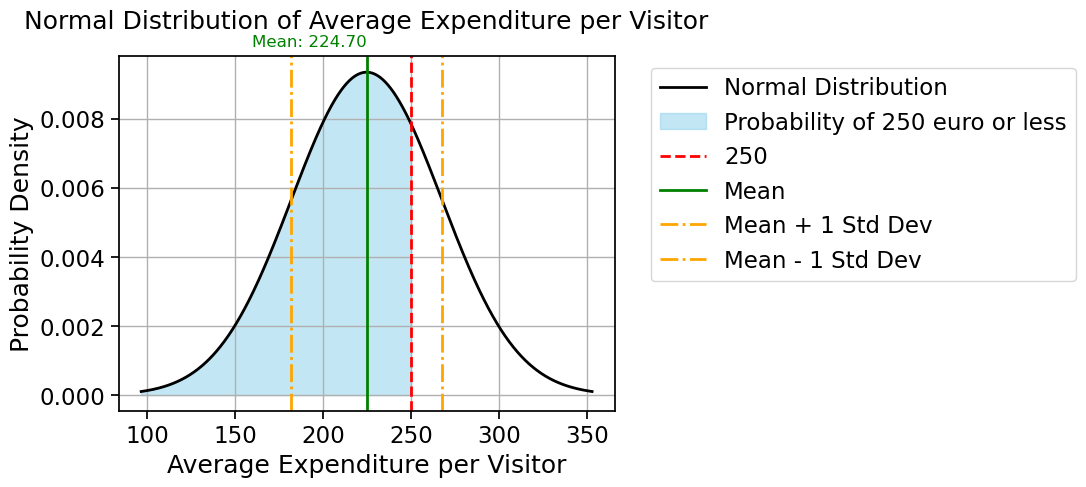

In [113]:
# Parameters for the normal distribution
mu = 224.7  # Mean
sigma = 42.7  # Standard deviation

# Calculate the probability of spending 250 euro or less
prob_less_than_250 = norm.cdf(250, loc=mu, scale=sigma)
print("Probability of spending 250 euro or less:", prob_less_than_250)

# Plot the normal distribution
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
plt.plot(x, norm.pdf(x, mu, sigma), 'k-', label='Normal Distribution')

# Highlight the area which corresponds to spending 250 or less
plt.fill_between(x, 0, norm.pdf(x, mu, sigma), where=(x <= 250), color='skyblue', alpha=0.5, label='Probability of 250 euro or less')

# Add line at 250 to show value we're checking for
plt.axvline(x=250, color='red', linestyle='--', label='250')

# Add mean line
plt.axvline(x=mu, color='green', linestyle='-', label='Mean')

# Add lines for mean plus and minus 1 STD (1st IQR)
plt.axvline(x=mu + sigma, color='orange', linestyle='-.', label='Mean + 1 Std Dev')
plt.axvline(x=mu - sigma, color='orange', linestyle='-.', label='Mean - 1 Std Dev')

# Add average expenditure value
plt.text(mu, 0.01, f'Mean: {mu:.2f}', verticalalignment='bottom', horizontalalignment='right', color='green', fontsize=12)

# Label graph
plt.xlabel('Average Expenditure per Visitor')
plt.ylabel('Probability Density')
plt.title('Normal Distribution of Average Expenditure per Visitor', pad=20)  # Increase space between title and plot
plt.subplots_adjust(top=0.85)  # Adjust space between title and plot

# Add legend outside the plot so doesn't block
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')



# plot graph
plt.grid(True)
plt.show()

68% of data falls within 1 std of the mean, 95% falls within 2 std and 99.7% falls within 3 std.... what does that mean for this data?

In [114]:
# Creating a loop to calculate the range for 1, 2, and 3 standard deviations
for num_std in range(1, 4):
    range_low = mu - num_std * sigma
    range_high = mu + num_std * sigma
    # Display the results for each range
    print(f"Approximately {68 if num_std == 1 else 95 if num_std == 2 else 99.7}% of the data falls between: {range_low} to {range_high}")
      

Approximately 68% of the data falls between: 182.0 to 267.4
Approximately 95% of the data falls between: 139.29999999999998 to 310.1
Approximately 99.7% of the data falls between: 96.59999999999997 to 352.8


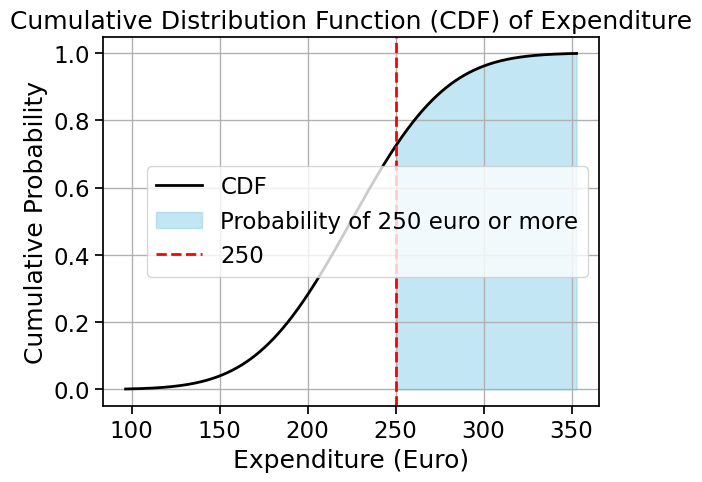

In [115]:
# Values being used for the normal distribution
mu = 224.7  # Mean
sigma = 42.7  # Standard deviation

# Calculate the probability of spending 250 euro or more
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
cdf_values = norm.cdf(x, mu, sigma)

# Plot the cumulative distribution function (CDF)
plt.plot(x, cdf_values, 'k-', label='CDF')

# Highlight the area corresponding to spending 250 or more
plt.fill_between(x, 0, cdf_values, where=(x >= 250), color='skyblue', alpha=0.5, label='Probability of 250 euro or more')

# Add line at 250
plt.axvline(x=250, color='red', linestyle='--', label='250')

# Label graph
plt.xlabel('Expenditure (Euro)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function (CDF) of Expenditure')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

# Machine Learning

In [116]:
#import libraries for machine learning models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics 
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler


In [117]:
#Scaling to improve ML
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale "Visitors" column
df_no_covid['Scaled_Visitors'] = scaler.fit_transform(df_no_covid[['Visitors']])

# Display the first few rows of the DataFrame
print(df_no_covid.head())


        Date        Country  Visitors  Month  Year   Latitude  Longitude  \
0 2010-01-01  Great Britain  361500.0      1  2010  54.315159  -1.918153   
1 2010-01-01        Belgium   12500.0      1  2010  50.640281   4.666715   
2 2010-01-01        Germany   45300.0      1  2010  51.163818  10.447831   
3 2010-01-01          Spain   68600.0      1  2010  39.326068  -4.837979   
4 2010-01-01         France   48900.0      1  2010  46.603354   1.888334   

   Scaled_Visitors  
0         0.442871  
1         0.009439  
2         0.050174  
3         0.079111  
4         0.054645  


# Classification
## I Want to Classify Every Month in my Data Set into 1 of 3 Categories: Low, Medium or High.
### This will be dependent on the total number of visitors arriving in the given month

In [118]:
# Function to categorize visitors into 5 categories
def categorize_visitors(visitors):
    quantiles = aggregated_data['Visitors'].quantile([0.25, 0.5, 0.75]).to_list()
    if visitors <= quantiles[0]:
        return 'Very Low'
    elif visitors <= quantiles[1]:
        return 'Low'
    elif visitors <= quantiles[2]:
        return 'Medium'
    else:
        return 'High'

In [119]:
aggregated_data.head()

Date   Visitors
0 2010-01-01   708200.0
1 2010-02-01   746300.0
2 2010-03-01   923500.0
3 2010-04-01   846300.0
4 2010-05-01  1027800.0

In [120]:
# Categorize visitors
aggregated_data['Category'] = aggregated_data['Visitors'].apply(categorize_visitors)

In [121]:
#make sure data in correct format
aggregated_data['Year'] = aggregated_data['Date'].dt.year
aggregated_data['Month'] = aggregated_data['Date'].dt.month

In [122]:
# Prepare data for the classifier
X = aggregated_data[['Year', 'Month']]  # Features
y = aggregated_data['Category']  # Target

In [123]:
# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [124]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42)
X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((146, 2), (146,), (109, 2), (37, 2), (109,), (37,))

In [125]:
# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

In [126]:
# Define parameter grid for RandomizedSearchCV
param_dist = {'n_estimators': [100, 200, 300, 400, 500],
              'max_depth': [None, 10, 20, 30, 40, 50],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'bootstrap': [True, False]}

In [127]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

In [128]:
# Fit the model
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [129]:
# Predict on the test set 
y_pred = random_search.predict(X_test)

# Classification report
classification_report_str = classification_report(y_test, y_pred, target_names=le.classes_)

In [130]:
print("Best Parameters:", best_params)

Best Parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': False}


In [131]:
print(classification_report_str)

              precision    recall  f1-score   support

        High       0.75      0.75      0.75        12
         Low       0.58      0.88      0.70         8
      Medium       0.20      0.12      0.15         8
    Very Low       0.88      0.78      0.82         9

    accuracy                           0.65        37
   macro avg       0.60      0.63      0.61        37
weighted avg       0.63      0.65      0.63        37



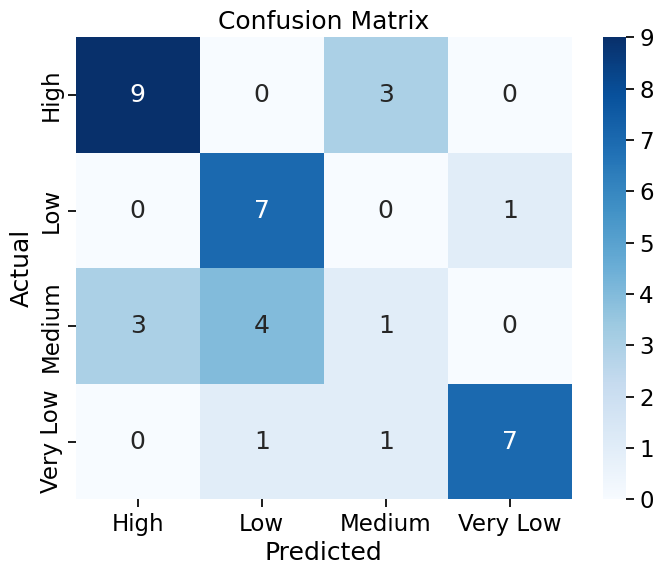

In [132]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Iqbal, M. (2024a). Lecture 1. [Lecture].

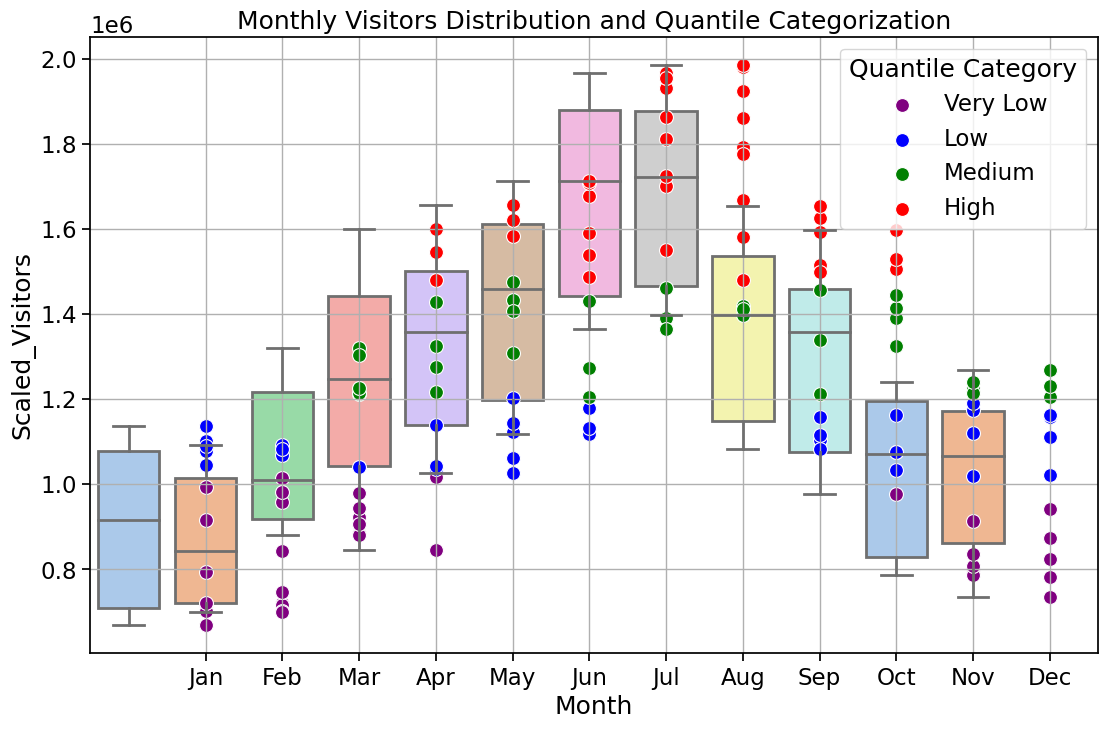

In [133]:
#visualise my results for entire dataframe

# Create a box plot to show the distribution of visitors for each month
plt.figure(figsize=(13, 8))
sns.boxplot(x='Month', y='Visitors', data=aggregated_data, palette='pastel', order=range(1, 13))

# I want to add a scatterplot to show individual months
# assign colors to each category
quantile_colors = {'Very Low': 'purple','Low': 'blue', 'Medium': 'green', 'High': 'red'}
for quantile, color in quantile_colors.items():
    # Filter data for each category
    quantile_data = aggregated_data[aggregated_data['Category'] == quantile]
    sns.scatterplot(x='Month', y='Visitors', data=quantile_data, color=color, label=quantile, s=100)
    
#label and plot graph
plt.title('Monthly Visitors Distribution and Quantile Categorization')
plt.xlabel('Month')
plt.ylabel('Scaled_Visitors')
plt.legend(title='Quantile Category')
plt.grid(True)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()

Iqbal, M. (2024a). Lecture 1. [Lecture].seaborn.pydata.org. (2012a). Overview of seaborn plotting functions — seaborn 0.12.0 documentation. [online] Available at: https://seaborn.pydata.org/tutorial/function_overview.html.

In [134]:
# Create a dictionary to store mode categories for each month
mode_categories_by_month = {}

# Loop through each month 
for month in range(1, 13):
    # Filter the dataset to includerows where the "Month" column = month we are looping through
    month_data = aggregated_data[aggregated_data["Month"] == month]
    
    # Calculate the mode of the "Category" column for month in loop
    month_mode_category = month_data["Category"].mode()[0]
    
    # Store result in the dictionary
    mode_categories_by_month[month] = month_mode_category

# Print mode categories for each month
for month, mode_category in mode_categories_by_month.items():
    print(f"Mode category for month {month}: {mode_category}")

Mode category for month 1: Very Low
Mode category for month 2: Very Low
Mode category for month 3: Very Low
Mode category for month 4: Medium
Mode category for month 5: Low
Mode category for month 6: High
Mode category for month 7: High
Mode category for month 8: High
Mode category for month 9: High
Mode category for month 10: Low
Mode category for month 11: Very Low
Mode category for month 12: Very Low


# Linear Regression using all Data from 2010 to December 2023

In [135]:
#set data so we can calculate days past
aggregated_data['Date'] = pd.to_datetime(aggregated_data['Date'])
aggregated_data['DateNumeric'] = (aggregated_data['Date'] - aggregated_data['Date'].min()).dt.days

In [136]:
# Step 3: Prepare the data for linear regression by assigning feature and target values
X = aggregated_data['Date'].apply(lambda x: (x - aggregated_data['Date'].min()).days).values.reshape(-1, 1)  # Convert Date to numerical values
y = aggregated_data['Visitors'].values.reshape(-1, 1)

# Step 4: Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Step 5: Predict the visitors for January 2024
date_2024 = np.datetime64('2024-07-01')
days_past = (date_2024 - aggregated_data['Date'].min()).days
visitors_2024 = model.predict([[days_past]])

print("Predicted Visitors for July 2024:", visitors_2024) 

Predicted Visitors for July 2024: [[1586706.27730021]]


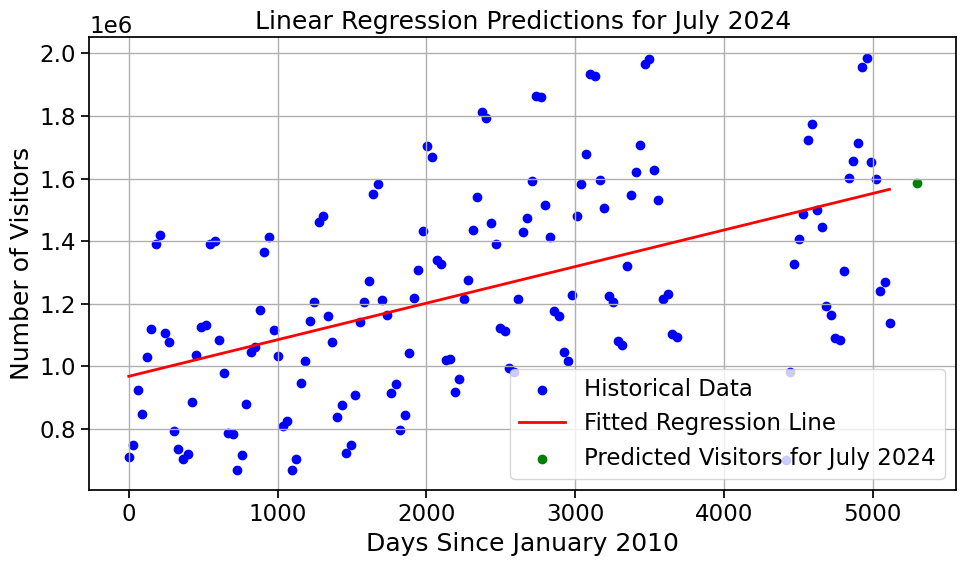

In [137]:
# Visualize the data and predictions
plt.figure(figsize=(10, 6))

# Plot total visitors history
plt.scatter(X, y, color='blue', label='Historical Data')

# Insert regression line
plt.plot(X, model.predict(X), color='red', label='Fitted Regression Line')

# Plot predicted value for July 2024
plt.scatter(days_past, visitors_2024, color='green', label='Predicted Visitors for July 2024')

# Add labels and legend
plt.title('Linear Regression Predictions for July 2024')
plt.xlabel('Days Since January 2010')
plt.ylabel('Number of Visitors')
plt.legend()

# Plot graph
plt.grid(True)
plt.tight_layout()
plt.show()

Iqbal, M. (2024a). Lecture 3. [Lecture].

## Decision Tree Regression to Predict Number of Tourists in January 2024 Based off of Pre-Covid Trends

In [138]:
# Extract year and month from the Date
aggregated_data['Year'] = pd.DatetimeIndex(aggregated_data['Date']).year
aggregated_data['Month'] = pd.DatetimeIndex(aggregated_data['Date']).month

In [139]:
# Split the data into features and targets
X = aggregated_data[['Year','Month']]
y = aggregated_data['Visitors']

In [140]:
# Craete training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=42)
X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((146, 2), (146,), (119, 2), (27, 2), (119,), (27,))

In [141]:
# Define the model
model = DecisionTreeRegressor(random_state=42)

# set the parameter grid
param_grid = {'max_depth': [None, 5, 10, 15, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],}

In [142]:
# Setup GridSearchCV
grid_search = GridSearchCV(model, param_grid , cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV on X_train and y_train
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [143]:
#Make predictions using the best estimator
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse}")

# Calculate R squared
r_squared = r2_score(y_test, y_pred)
print(f"Test R2:r_squared:{r_squared}")

mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse}")

Test RMSE: 100624.49999875776
Test R2:r_squared:0.9297779628267216
Test MSE: 10125290000.0


In [144]:
# Prediction for July 2024
prediction_input = pd.DataFrame({'Year': [2024], 'Month': [7]})

# Predict using the optimized model
predicted_visitors_2024 = grid_search.best_estimator_.predict(prediction_input)

print("Predicted Total Visitors for July 2024:", predicted_visitors_2024[0])

Predicted Total Visitors for July 2024: 1985700.0


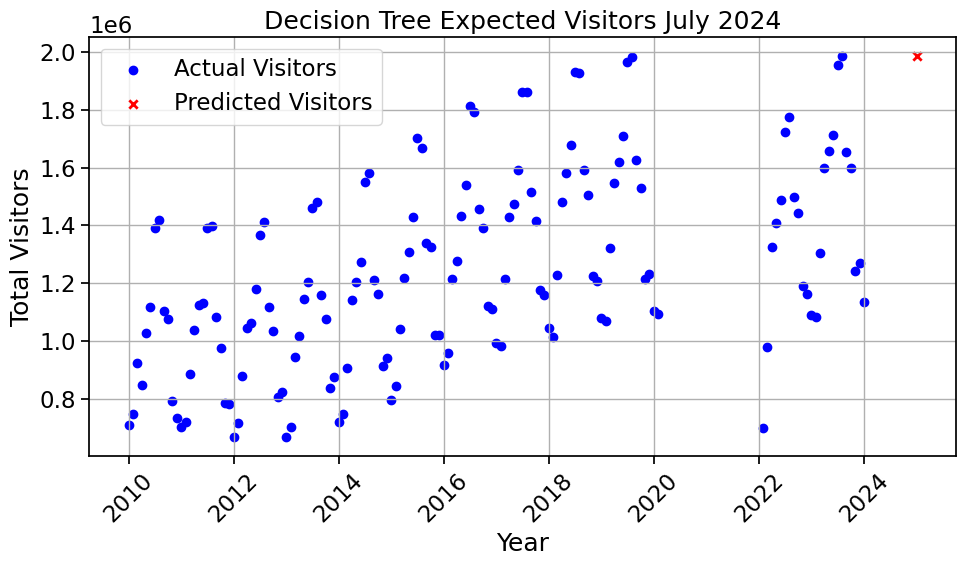

In [145]:
#assign figure size
plt.figure(figsize=(10, 6))

# Plotting the actual visitors as a scatter plot
plt.scatter(aggregated_data['Date'], aggregated_data['Visitors'], label='Actual Visitors', color='blue', marker='o')

# Plotting the predicted visitor count for July 2024
prediction_dates = pd.date_range(start='2024-07-01', periods=len(predicted_visitors_2024), freq='YS')
plt.scatter(prediction_dates, predicted_visitors_2024, label='Predicted Visitors', color='red', marker='x')

#plot graph
plt.title('Decision Tree Expected Visitors July 2024')
plt.xlabel('Year')
plt.ylabel('Total Visitors')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Iqbal, M. (2024a). Lecture 2. [Lecture].

## Random Forest Regressor to Predict Visitors in January 2024 Based off Pre-covid Trends 

In [146]:
# Split the data into features and targets
X = aggregated_data[['Year','Month']]
y = aggregated_data['Visitors']

In [147]:
# Craete training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((146, 2), (146,), (116, 2), (30, 2), (116,), (30,))

In [148]:
# Define the parameter grid for Random Forest Regressor
param_grid = {'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],}

In [149]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit to data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Make predictions using the best estimator
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate R^2 
r_squared = r2_score(y_test, y_pred)
print(f"Test R2: {r_squared}")

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse}")

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse}")

NameError: name 'regressor' is not defined

In [ ]:
# Initialize the regressor
regressor = RandomForestRegressor()

In [ ]:
# Predict arrivals for July 2024
predicted_visitors_2024 = grid_search.predict([[2024,7]])

print(f"Predicted number of visitors in July 2024: {predicted_visitors_2024[0]}")

In [ ]:
#improving my model
# Initialize the regressor with the best parameters
best_regressor = RandomForestRegressor(max_depth=10, n_estimators=100)

# Fit the regressor 
best_regressor.fit(X_train, y_train)

# Predict on the test set using the best regressor
y_pred = best_regressor.predict(X_test)

# R-squared score
r_squared = r2_score(y_test, y_pred)
print(f"Test R2 Score: {r_squared}")

# Calculate the MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse}")

# Predicting visitors for July 2024 (updated)
predicted_visitors_2024 = best_regressor.predict([[2024, 7]])

print(f"Predicted number of visitors in July 2024: {predicted_visitors_2024[0]}")

In [ ]:
predicted_date = pd.to_datetime('2024-07')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(aggregated_data['Date'], aggregated_data['Visitors'], marker='o', linestyle='-', label='Actual Visitors')
plt.scatter(predicted_date, predicted_visitors_2024[0], color='red', label='Predicted Visitors for July 2024', zorder=5)

plt.title('Random Forest Regressor Expected Visitors July 2024')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Iqbal, M. (2024a). Lecture 2. [Lecture].